In [1]:
using Interpolations
using Dierckx
using NPZ
using DifferentialEquations
using Plots
using PyPlot 
import PyPlot
using LaTeXStrings
using Statistics

[ Info: Precompiling Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
[ Info: Precompiling Dierckx [39dd38d3-220a-591b-8e3c-4c3a8c710a94]
[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
ERROR: LoadError: LoadError: syntax: invalid assignment location "state..." around /users/jmhamilton/.julia/packages/ModelingToolkit/r5ZaU/src/bipartite_graph.jl:365
Stacktrace:
 [1] top-level scope at /users/jmhamilton/.julia/packages/ModelingToolkit/r5ZaU/src/bipartite_graph.jl:364
 [2] include(::Function, ::Module, ::String) at ./Base.jl:380
 [3] include at ./Base.jl:368 [inlined]
 [4] include(::String) at /users/jmhamilton/.julia/packages/ModelingToolkit/r5ZaU/src/ModelingToolkit.jl:4
 [5] top-level scope at /users/jmhamilton/.julia/packages/ModelingToolkit/r5ZaU/src/ModelingToolkit.jl:110
 [6] include(::Function, ::Module, ::String) at ./Base.jl:380
 [7] include(::Module, ::String) at ./Base.jl:368
 [8] top-level scope at none:2
 [9] eval at ./boot.jl:331 [inl

LoadError: [91mFailed to precompile DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa] to /users/jmhamilton/.julia/compiled/v1.5/DifferentialEquations/UQdwS_iNCSo.ji.[39m

In [2]:
#filepath = "/net/scratch3/giannis_kx/pixie3d/tests/bonfiglio_div_tok/python_arrays/";
#filepath = "/net/scratch4/giannis_kx/pixie3d/iter/int_kink/orig/orig.scratch/";
#filepath = "/net/scratch3/giannis_kx/pixie3d/tests/sawtooth/python_arrays/";
filepath = "/net/scratch3/giannis_kx/pixie3d/tests/bonfiglio_div_tok/sawtooth2.scratch/pixie3d.h5";

In [3]:
psin_min_ind = 5;
psin_max_ind = 90;
psin_list = LinRange(0,1,101);

In [13]:
function dAdr(arr,theta,phi,t)
    dr = 1.0 / size(arr,1)
    psi_in = arr[:,theta,phi,t]
    psiplus = circshift(psi_in,(-1))
    psi2plus = circshift(psi_in,(-2))
    psiminus = circshift(psi_in,(1))
    psi2minus = circshift(psi_in,(2))
    dpsidr = (-psi2plus +8*psiplus - 8*psiminus + psi2minus)/(12.0*dr)
    dpsidr_two = (psi_in[3]-psi_in[1])/2*dr
    dpsidr_mtwo = (psi_in[length(psi_in)]-psi_in[length(psi_in)-2])/2*dr
    dpsidr_start = (psi_in[2]-psi_in[1])/dr
    dpsidr_end = (psi_in[length(psi_in)]-psi_in[length(psi_in)-1])/dr
    dpsidr[1] = dpsidr_start
    dpsidr[2] = dpsidr_two
    dpsidr[length(psi_in)-1] = dpsidr_mtwo
    dpsidr[length(psi_in)] = dpsidr_end
    return dpsidr
end

function dAdt(arr,r,phi,t)
    dtheta = 2.0*pi / size(arr,2)
    p = arr[r,:,phi,t]
    L = length(p)
    dpsidtheta = zeros(L)
    for i in range(1,stop=L)
        if i==1
            dpsidtheta[i] = (-p[3]+8*p[2]-8*p[L-1]+p[L-2])/(12.0*dtheta)
        elseif i==2
            dpsidtheta[i] = (-p[4]+8*p[3]-8*p[1]+p[L-1])/(12.0*dtheta)
        elseif i==L-1
            dpsidtheta[L-1] = (-p[2]+8*p[1]-8*p[L-2]+p[L-3])/(12.0*dtheta)
        elseif i==L-2
            dpsidtheta[L-2] = (-p[1]+8*p[L-1]-8*p[L-3]+p[L-4])/(12.0*dtheta)
        elseif i==L
            dpsidtheta[L] = dpsidtheta[1]
        else
            dpsidtheta[i] = (-p[i+2]+8*p[i+1]-8*p[i-1]+p[i-2])/(12.0*dtheta)
        end
    end
    return dpsidtheta
end
    
    

function dpsi_dr(arr)
    r_deriv = Float64[] 
    for theta in range(1,stop=size(arr,2))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                r_deriv = append!(r_deriv,dAdr(arr,theta,phi,t))
            end
        end
    end
     # In Julia the convention in reshape is the opposite of Python
    return permutedims(reshape(r_deriv,(size(arr,1),size(arr,4),size(arr,3),size(arr,2))),(1,4,3,2))
end

function dpsi_dtheta(arr)
    t_deriv = Float64[] 
    for r in range(1,stop=size(arr,1))
        for phi in range(1,stop=size(arr,3))
            for t in range(1,stop=size(arr,4))
                t_deriv = append!(t_deriv,dAdt(arr,r,phi,t))
            end
        end
    end
    return permutedims(reshape(t_deriv,(size(arr,2),size(arr,4),size(arr,3),size(arr,1))),(4,1,3,2))
end

dpsi_dtheta (generic function with 1 method)

In [84]:
function Flux_surface!(du,u,p,t)
    du[1] = -(abs(dpsidr_eint(u[1],u[2],0.0,p))/dpsidr_eint(u[1],u[2],0.0,p))*(dpsidtheta_eint(u[1],u[2],0.0,p)/(sqrt((dpsidtheta_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(dpsidr_eint(u[1],u[2],0.0,p))^2)))
    du[2] = abs(dpsidr_eint(u[1],u[2],0.0,p))/(sqrt((dpsidtheta_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(dpsidr_eint(u[1],u[2],0.0,p))^2))
    du[3] = -(abs(dpsidr_eint(u[1],u[2],0.0,p))/dpsidr_eint(u[1],u[2],0.0,p))*B3_eint(u[1],u[2],0.0,p)/(sqrt((dpsidtheta_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(dpsidr_eint(u[1],u[2],0.0,p))^2))
end


function condition(u,t,integrator)
    #u[2] > 2*pi
    abs(u[2]) - 2*pi#0.0 #|| abs(u[2]) - 2*pi  
end

function affect!(integrator)
    terminate!(integrator)
end

#cb = DiscreteCallback(condition,affect!)
cb = ContinuousCallback(condition,affect!,rootfind = true)

function monitor(integrator)
    for (t,u) in tuples(integrator)
        @show t,u
    end
end

"""Solver call"""
function fs_integration(rs,us,time)
    u0 = [rs,us,0.0]
    p = time
    tspan = (0.0,18.0)
    prob = ODEProblem(Flux_surface!,u0,tspan,p)
    integrator = init(prob,Vern9(),callback=cb,reltol=1.e-10,abstol=1.e-10)
    sol =solve(prob,Vern9(),callback=cb,reltol=1.e-10,abstol=1.e-10)
    monitor(integrator)
    return sol
end

fs_integration

In [83]:
t = 26
sol = fs_integration(r_of_psi[t,6],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 25%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.03,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(X[1,1,1],Z[1,1,1],"rx")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

(t, u) = ([0.1727784314761054, 0.07665793379082655, -0.12612284316672395], 0.01327333464882229)
(t, u) = ([0.172465207618565, 0.09922807598518443, -0.16327292011588357], 0.017182296431129562)
(t, u) = ([0.17206257803817065, 0.12152008490730966, -0.19998412223319167], 0.021043701095546773)
(t, u) = ([0.17072726467759525, 0.17640207918850104, -0.2904701012806252], 0.03054756323685443)
(t, u) = ([0.16979227577082717, 0.20684007173045402, -0.34073253697423483], 0.03581409541546411)
(t, u) = ([0.16912339273162863, 0.22625193505001873, -0.3728225166497437], 0.03917103791862643)
(t, u) = ([0.16629099519101234, 0.29491090325048097, -0.48659873621566424], 0.05103495491253333)
(t, u) = ([0.16244129031224308, 0.36872829516279476, -0.6095626615361819], 0.06377139301648872)
(t, u) = ([0.15913757469715067, 0.42231250977109097, -0.6993896190339117], 0.07300159887452926)
(t, u) = ([0.15588571712821248, 0.469341739584754, -0.7787387132206908], 0.08109345301947177)
(t, u) = ([0.15156454595405966, 0.5255

(t, u) = ([0.04071078158104576, 1.174415845892651, -2.3083687835628344], 0.22990187715503757)
(t, u) = ([0.04071078157777591, 1.174415845892651, -2.3083687838260905], 0.22990187718165525)
(t, u) = ([0.040710781570127315, 1.174415845892651, -2.3083687840983482], 0.2299018772091831)
(t, u) = ([0.04071078154383345, 1.174415845892651, -2.3083687843911207], 0.22990187723878514)
(t, u) = ([0.04071078156634992, 1.174415845892651, -2.3083687846138146], 0.2299018772613016)
(t, u) = ([0.040710781584128886, 1.174415845892651, -2.3083687850851624], 0.2299018773089593)
(t, u) = ([0.04071078158007007, 1.174415845892651, -2.3083687854119384], 0.22990187734199943)
(t, u) = ([0.0407107815706365, 1.174415845892651, -2.3083687857477337], 0.2299018773759515)
(t, u) = ([0.04071078154181343, 1.174415845892651, -2.3083687860686677], 0.22990187740840096)
(t, u) = ([0.04071078156654955, 1.174415845892651, -2.3083687863133147], 0.2299018774331371)
(t, u) = ([0.040710781582843074, 1.174415845892651, -2.308368786

(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308368819216238], 0.22990188075993262)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083688195177503], 0.22990188079041834)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308368819828324], 0.22990188082182028)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083688201608967], 0.22990188085544652)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308368820412838], 0.22990188088092015)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308368820915616], 0.22990188093175576)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083688212624374], 0.22990188096682265)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308368821618203], 0.22990188100279393)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308368821921964], 0.22990188103350703)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083688221551117], 0.22990188105708045)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.30836882

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /users/giannis_kx/.julia/packages/DiffEqBase/b38LC/src/integrator_interface.jl:329


([0.04071078155521512, 1.174415845892651, -2.3083688274098075], 0.2299018815883797)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083688277566288], 0.2299018816234466)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083688281123944], 0.22990188165941788)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083688284161554], 0.22990188169013098)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308368828649303], 0.2299018817137044)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083688290221707], 0.22990188175140483)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.308368829285427], 0.22990188177802257)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083688295576854], 0.22990188180555043)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083688298504583], 0.22990188183515253)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.3083688300731526], 0.22990188185766902)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.308368830544501]

(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083688625441097], 0.22990188514078877)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308368863015458], 0.2299018851884465)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083688633422343], 0.22990188522148666)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083688636780297], 0.22990188525543875)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308368863998964], 0.22990188528788824)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083688642436115], 0.22990188531262437)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308368864675578], 0.22990188535630027)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.30836886497709], 0.229901885386786)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308368865287664], 0.22990188541818793)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.3083688656202366], 0.22990188545181417)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308368865872177

(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083688983431347], 0.22990188876040754)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308368898845913], 0.22990188881124315)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083688991927342], 0.22990188884631005)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083688995485], 0.22990188888228133)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308368899852261], 0.22990188891299443)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083689000854086], 0.22990188893656785)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308368900458276], 0.22990188897426828)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083689007215327], 0.229901889000886)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308368900993791], 0.22990188902841388)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.308368901286564], 0.22990188905801598)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.30836890150

(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083689412725312], 0.22990189310097406)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083689416083266], 0.22990189313492615)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308368941929261], 0.22990189316737564)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083689421739084], 0.22990189319211177)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308368942605875], 0.22990189323578766)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.308368942907387], 0.2299018932662734)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308368943217961], 0.22990189329767532)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.3083689435505335], 0.22990189333130157)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083689438024746], 0.2299018933567752)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.308368944305253], 0.2299018934076108)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.30836894465207

(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308368977123031], 0.22990189672579744)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083689774787968], 0.22990189676176873)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308368977782558], 0.22990189679248182)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083689780157055], 0.22990189681605525)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308368978388573], 0.22990189685375567)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083689786518296], 0.2299018968803734)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083689789240878], 0.22990189690790128)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083689792168607], 0.22990189693750337)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.308368979439555], 0.22990189696001986)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083689799109033], 0.2299018970076776)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083689

(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083690173537215], 0.22990190079349937)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369017616978], 0.2299019008201171)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308369017889236], 0.22990190084764497)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.308369018182009], 0.22990190087724707)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083690184047034], 0.22990190089976356)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083690188760517], 0.2299019009474213)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.308369019202828], 0.22990190098046145)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083690195386235], 0.22990190101441355)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308369019859558], 0.22990190104686303)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083690201042053], 0.22990190107159916)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.30836902053

(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369053007129], 0.2299019043983948)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.308369053308641], 0.22990190442888053)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083690536192147], 0.22990190446028247)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083690539517874], 0.2299019044939087)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083690542037285], 0.22990190451938233)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083690547065068], 0.22990190457021795)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308369055053328], 0.22990190460528484)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083690554090937], 0.22990190464125612)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083690557128547], 0.22990190467196922)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083690559460024], 0.22990190469554264)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083690

(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083690912956634], 0.22990190826972648)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.308369091540311], 0.2299019082944626)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083690919722772], 0.2299019083381385)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083690922737894], 0.22990190836862423)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369092584363], 0.22990190840002617)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308369092916936], 0.2299019084336524)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308369093168877], 0.22990190845912603)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308369093671655], 0.22990190850996164)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083690940184765], 0.22990190854502854)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308369094374242], 0.22990190858099982)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.30836909467

(t, u) = ([0.040710781596798265, 1.174415845892651, -2.30836912714896], 0.22990191189483267)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308369127382108], 0.2299019119184061)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083691277549754], 0.2299019119561065)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.308369128018232], 0.22990191198272425)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.30836912829049], 0.22990191201025212)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.308369128583263], 0.22990191203985422)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.3083691288059573], 0.2299019120623707)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083691292773056], 0.22990191211002844)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.308369129604082], 0.2299019121430686)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.3083691299398774], 0.2299019121770207)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308369130260812]

(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083691646049824], 0.22990191568198948)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.3083691651077607], 0.2299019157328251)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.308369165454582], 0.22990191576789198)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083691658103476], 0.22990191580386327)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083691661141086], 0.22990191583457636)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083691663472563], 0.22990191585814979)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369166720124], 0.2299019158958502)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083691669833803], 0.22990191592246795)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083691672556386], 0.22990191594999582)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083691675484115], 0.22990191597959792)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369

(t, u) = ([0.040710781573808016, 1.174415845892651, -2.308369200242063], 0.22990191928523415)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308369200713411], 0.2299019193328919)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083692010401875], 0.22990191936593204)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.308369201375983], 0.22990191939988414)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083692016969173], 0.22990191943233362)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083692019415647], 0.22990191945706975)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308369202373531], 0.22990191950074565)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083692026750433], 0.22990191953123137)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308369202985617], 0.2299019195626333)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.3083692033181897], 0.22990191959625955)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083692035701

(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083692381562293], 0.22990192311871366)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369238419486], 0.2299019231453314)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308369238691744], 0.22990192317285926)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.308369238984517], 0.22990192320246136)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083692392072113], 0.22990192322497785)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083692396785596], 0.2299019232726356)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.308369240005336], 0.22990192330567574)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083692403411313], 0.22990192333962783)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083692406620657], 0.22990192337207732)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.308369240906713], 0.22990192339681345)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.30836924133

(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083692738096366], 0.2299019267236091)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.308369274111149], 0.22990192675409482)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083692744217226], 0.22990192678549676)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308369274754295], 0.229901926819123)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083692750062363], 0.22990192684459662)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083692755090146], 0.22990192689543223)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308369275855836], 0.22990192693049913)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083692762116015], 0.2299019269664704)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083692765153625], 0.2299019269971835)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083692767485102], 0.22990192702075693)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083692771

(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308369312098171], 0.22990193059494077)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.3083693123428186], 0.2299019306196769)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369312774785], 0.2299019306633528)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083693130762972], 0.22990193069383852)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369313386871], 0.22990193072524046)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083693137194436], 0.2299019307588667)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308369313971385], 0.22990193078434032)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308369314474163], 0.22990193083517593)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083693148209843], 0.22990193087024283)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.30836931517675], 0.2299019309062141)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083693154805

(t, u) = ([0.040710781596798265, 1.174415845892651, -2.308369347951468], 0.22990193422004696)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083693481846157], 0.22990193424362038)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369348557483], 0.2299019342813208)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083693488207397], 0.22990193430793854)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.308369349092998], 0.2299019343354664)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.308369349385771], 0.2299019343650685)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369349608465], 0.229901934387585)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083693500798135], 0.22990193443524273)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.30836935040659], 0.2299019344682829)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.3083693507423853], 0.22990193450223498)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083693510633196

(t, u) = ([0.04071078155731487, 1.174415845892651, -2.3083693842108906], 0.22990193788621624)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083693845124027], 0.22990193791670196)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.3083693848229765], 0.2299019379481039)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.308369385155549], 0.22990193798173014)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083693854074903], 0.22990193800720377)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.3083693859102685], 0.22990193805803938)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083693862570898], 0.22990193809310627)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083693866128554], 0.22990193812907755)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083693869166164], 0.22990193815979065)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308369387149764], 0.22990193818336407)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369

(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083694199935887], 0.22990194150418425)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369420256845], 0.22990194153080198)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083694205291034], 0.22990194155832985)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083694208218763], 0.22990194158793195)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083694210445707], 0.22990194161044844)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308369421515919], 0.22990194165810618)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083694218426953], 0.22990194169114633)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083694221784907], 0.22990194172509842)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308369422499425], 0.2299019417575479)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083694227440725], 0.22990194178228404)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.30836942

(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369456259082], 0.22990194517096735)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083694565916546], 0.2299019452045936)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083694568435957], 0.2299019452300672)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308369457346374], 0.22990194528090283)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083694576931952], 0.22990194531596972)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308369458048961], 0.229901945351941)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308369458352722], 0.2299019453826541)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083694585858696], 0.22990194540622752)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308369458958737], 0.22990194544392795)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083694592219937], 0.22990194547054568)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308369459494

(t, u) = ([0.04071078157007897, 1.174415845892651, -2.308369491965209], 0.2299019487811933)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.308369492257982], 0.2299019488107954)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369492480676], 0.2299019488333119)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083694929520244], 0.22990194888096963)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.308369493278801], 0.22990194891400978)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.308369493614596], 0.22990194894796187)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083694939355306], 0.22990194898041136)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.308369494180178], 0.2299019490051475)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083694946121445], 0.22990194904882338)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083694949136566], 0.2299019490793091)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083694952242304

(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308369528279701], 0.22990195245293066)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.3083695287824795], 0.22990195250376627)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083695291293007], 0.22990195253883317)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083695294850664], 0.22990195257480445)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083695297888274], 0.22990195260551755)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308369530021975], 0.22990195262909097)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083695303948426], 0.2299019526667914)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.308369530658099], 0.22990195269340913)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083695309303573], 0.229901952720937)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083695312231303], 0.2299019527505391)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369531

(t, u) = ([0.04071078156688473, 1.174415845892651, -2.308369562492932], 0.22990195591221071)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083695628657996], 0.22990195594991114)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369563129056], 0.22990195597652888)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083695634013144], 0.22990195600405675)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083695636940873], 0.22990195603365884)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083695639167816], 0.22990195605617533)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.30836956438813], 0.22990195610383307)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083695647149063], 0.22990195613687323)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083695650507017], 0.22990195617082532)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308369565371636], 0.2299019562032748)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083695656

(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308369597842593], 0.22990195948639455)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.3083695980872405], 0.22990195951113068)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369598519207], 0.22990195955480658)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.308369598820719], 0.2299019595852923)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369599131293], 0.22990195961669424)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083695994638656], 0.22990195965032048)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083695997158067], 0.2299019596757941)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308369600218585], 0.22990195972662972)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308369600565406], 0.2299019597616966)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308369600921172], 0.2299019597976679)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083696012249

(t, u) = ([0.040710781596798265, 1.174415845892651, -2.30836963369589], 0.22990196311150074)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083696339290376], 0.22990196313507416)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369634301905], 0.2299019631727746)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083696345651616], 0.22990196319939232)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.30836963483742], 0.2299019632269202)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083696351301928], 0.2299019632565223)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369635352887], 0.22990196327903878)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083696358242354], 0.22990196332669652)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.3083696361510118], 0.22990196335973667)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.308369636486807], 0.22990196339368876)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083696368077

(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083696692786986], 0.229901966709258)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.308369669523346], 0.22990196673399413)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.3083696699553125], 0.22990196677767002)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083696702568246], 0.22990196680815575)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.3083696705673984], 0.2299019668395577)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.308369670899971], 0.22990196687318393)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308369671151912], 0.22990196689865755)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.3083696716546904], 0.22990196694949316)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083696720015117], 0.22990196698456006)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083696723572773], 0.22990196702053134)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083696726

(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083697051319954], 0.2299019703343642)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.308369705365143], 0.2299019703579376)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083697057380106], 0.22990197039563803)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369706001267], 0.22990197042225577)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083697062735253], 0.22990197044978364)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083697065662983], 0.22990197047938574)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083697067889926], 0.22990197050190223)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308369707260341], 0.22990197054955996)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083697075871172], 0.22990197058260012)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083697079229126], 0.2299019706165522)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.30836970

(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369741391418], 0.22990197400053347)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.30836974169293], 0.2299019740310192)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369742003504], 0.22990197406242113)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083697423360765], 0.22990197409604737)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083697425880176], 0.229901974121521)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308369743090796], 0.2299019741723566)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308369743437617], 0.2299019742074235)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083697437933828], 0.22990197424339479)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308369744097144], 0.22990197427410788)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083697443302915], 0.2299019742976813)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308369744703159

(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369777174116], 0.22990197761850148)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083697774373726], 0.22990197764511922)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.308369777709631], 0.22990197767264708)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083697780024037], 0.22990197770224918)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369778225098], 0.22990197772476567)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083697786964463], 0.2299019777724234)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.3083697790232227], 0.22990197780546356)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.308369779359018], 0.22990197783941566)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083697796799525], 0.22990197787186514)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.3083697799246], 0.22990197789660127)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369780356

(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083698166747793], 0.22990198161239078)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.308369816967552], 0.22990198164199288)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.3083698171902465], 0.22990198166450937)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083698176615948], 0.2299019817121671)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.308369817988371], 0.22990198174520726)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.3083698183241665], 0.22990198177915935)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308369818645101], 0.22990198181160884)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.3083698188897483], 0.22990198183634497)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308369819321715], 0.22990198188002087)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.308369819623227], 0.2299019819105066)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308369819933

(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308369852404758], 0.22990198522502828)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.3083698527373304], 0.22990198525865452)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083698529892716], 0.22990198528412814)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.30836985349205], 0.22990198533496375)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.308369853838871], 0.22990198537003065)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083698541946367], 0.22990198540600193)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083698544983977], 0.22990198543671503)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083698547315454], 0.22990198546028845)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369855104413], 0.22990198549798888)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083698553676695], 0.2299019855246066)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.308369855

(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083698881108847], 0.22990198883525423)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083698884036576], 0.22990198886485633)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.308369888626352], 0.22990198888737282)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083698890977002], 0.22990198893503055)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083698894244766], 0.2299019889680707)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.308369889760272], 0.2299019890020228)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083698900812064], 0.2299019890344723)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.308369890325854], 0.22990198905920842)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.3083698907578203], 0.2299019891028843)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083698910593324], 0.22990198913337004)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.3083698913699

(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083699238408633], 0.22990199244789172)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308369924173436], 0.22990199248151796)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308369924425377], 0.2299019925069916)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083699249281553], 0.2299019925578272)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083699252749765], 0.2299019925928941)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308369925630742], 0.22990199262886538)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308369925934503], 0.22990199265957847)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.308369926167651], 0.2299019926831519)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083699265405184], 0.22990199272085232)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308369926803775], 0.22990199274747006)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308369927076

(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308369961517312], 0.22990199625733573)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.3083699617619593], 0.22990199628207186)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083699621939258], 0.22990199632574776)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.308369962495438], 0.22990199635623348)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083699628060117], 0.22990199638763542)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083699631385843], 0.22990199642126166)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083699633905255], 0.22990199644673529)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083699638933037], 0.2299019964975709)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308369964240125], 0.2299019965326378)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083699645958906], 0.22990199656860907)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083699

(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083699973706087], 0.22990199988244192)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083699976037564], 0.22990199990601534)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308369997976624], 0.22990199994371577)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083699982398804], 0.2299019999703335)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083699985121386], 0.22990199999786137)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083699988049116], 0.22990200002746347)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.308369999027606], 0.22990200004997996)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.308369999498954], 0.2299020000976377)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.3083699998257305], 0.22990200013067785)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.308370000161526], 0.22990200016462994)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.308370000

(t, u) = ([0.04071078155731487, 1.174415845892651, -2.3083700336300312], 0.2299020035486112)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083700339315434], 0.22990200357909693)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308370034242117], 0.22990200361049887)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.30837003457469], 0.2299020036441251)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308370034826631], 0.22990200366959873)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.308370035329409], 0.22990200372043434)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083700356762304], 0.22990200375550124)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.308370036031996], 0.22990200379147252)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.308370036335757], 0.22990200382218562)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308370036568905], 0.22990200384575904)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083700369417

(t, u) = ([0.040710781580949075, 1.174415845892651, -2.3083700694127294], 0.22990200716657921)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.308370069675986], 0.22990200719319695)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308370069948244], 0.22990200722072482)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.308370070241017], 0.22990200725032692)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083700704637113], 0.2299020072728434)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083700709350596], 0.22990200732050114)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.308370071261836], 0.2299020073535413)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083700715976314], 0.2299020073874934)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308370071918566], 0.22990200741994288)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.308370072163213], 0.229902007444679)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308370072595179

(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308370108377878], 0.2299020111063229)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083701086411343], 0.22990201113294065)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083701089133926], 0.22990201116046852)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083701092061655], 0.22990201119007062)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.30837010942886], 0.2299020112125871)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308370109900208], 0.22990201126024484)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083701102269845], 0.229902011293285)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.30837011056278], 0.2299020113272371)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083701108837142], 0.22990201135968658)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083701111283617], 0.2299020113844227)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308370111560328]

(t, u) = ([0.04071078158279471, 1.174415845892651, -2.308370144031285], 0.22990201471121835)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083701443327973], 0.22990201474170407)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.308370144643371], 0.229902014773106)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083701449759437], 0.22990201480673225)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308370145227885], 0.22990201483220588)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308370145730663], 0.2299020148830415)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083701460774844], 0.22990201491810838)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.30837014643325], 0.22990201495407966)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308370146737011], 0.22990201498479276)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083701469701587], 0.22990201500836618)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308370147343

(t, u) = ([0.04071078156630156, 1.174415845892651, -2.3083701808649653], 0.22990201843545055)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.3083701813363136], 0.2299020184831083)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.30837018166309], 0.22990201851614844)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.3083701819988853], 0.22990201855010053)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083701823198197], 0.22990201858255002)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.308370182564467], 0.22990201860728615)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083701829964336], 0.22990201865096205)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083701832979457], 0.22990201868144777)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083701836085195], 0.2299020187128497)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308370183941092], 0.22990201874647595)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.30837018419

(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083702166639903], 0.22990202205506932)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.3083702171667686], 0.22990202210590494)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.30837021751359], 0.22990202214097183)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.3083702178693555], 0.2299020221769431)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083702181731165], 0.2299020222076562)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308370218406264], 0.22990202223122963)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083702187791317], 0.22990202226893006)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083702190423883], 0.2299020222955478)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083702193146465], 0.22990202232307566)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083702196074194], 0.22990202235267776)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.30837021

(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083702530991954], 0.2299020257390119)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.308370253434991], 0.22990202577296398)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308370253755925], 0.22990202580541347)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083702540005726], 0.2299020258301496)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308370254432539], 0.2299020258738255)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.308370254734051], 0.22990202590431122)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.308370255044625], 0.22990202593571316)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.3083702553771976], 0.2299020259693394)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308370255629139], 0.22990202599481302)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.308370256131917], 0.22990202604564863)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083702564787383]

(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083702889496953], 0.22990202936383528)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308370289305461], 0.22990202939980656)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.308370289609222], 0.22990202943051966)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083702898423697], 0.22990202945409308)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308370290215237], 0.2299020294917935)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083702904784937], 0.22990202951841124)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308370290750752], 0.2299020295459391)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.308370291043525], 0.2299020295755412)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.308370291266219], 0.2299020295980577)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083702917375675], 0.22990202964571543)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.30837029206

(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083703251920307], 0.22990203302827691)
(t, u) = ([0.04071078156650118, 1.174415845892651, -2.308370325436678], 0.22990203305301304)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083703258686445], 0.22990203309668894)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083703261701567], 0.22990203312717467)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083703264807305], 0.2299020331585766)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308370326813303], 0.22990203319220284)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083703270652443], 0.22990203321767647)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083703275680225], 0.22990203326851208)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083703279148438], 0.22990203330357897)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083703282706094], 0.22990203333955025)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.30837

(t, u) = ([0.040710781596798265, 1.174415845892651, -2.3083703610453274], 0.2299020366533831)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.308370361278475], 0.22990203667695652)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.3083703616513427], 0.22990203671465695)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.308370361914599], 0.22990203674127468)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.3083703621868574], 0.22990203676880255)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.3083703624796303], 0.22990203679840465)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.3083703627023247], 0.22990203682092114)
(t, u) = ([0.04071078158408054, 1.174415845892651, -2.308370363173673], 0.22990203686857888)
(t, u) = ([0.04071078158002172, 1.174415845892651, -2.3083703635004493], 0.22990203690161903)
(t, u) = ([0.04071078157058814, 1.174415845892651, -2.3083703638362447], 0.22990203693557112)
(t, u) = ([0.040710781541765044, 1.174415845892651, -2.3083703

(t, u) = ([0.04071078157417962, 1.174415845892651, -2.3083703985013497], 0.2299020404405399)
(t, u) = ([0.04071078155521512, 1.174415845892651, -2.308370399004128], 0.22990204049137553)
(t, u) = ([0.040710781559522916, 1.174415845892651, -2.3083703993509492], 0.22990204052644242)
(t, u) = ([0.040710781569517525, 1.174415845892651, -2.308370399706715], 0.2299020405624137)
(t, u) = ([0.040710781596798265, 1.174415845892651, -2.308370400010476], 0.2299020405931268)
(t, u) = ([0.04071078157322485, 1.174415845892651, -2.3083704002436236], 0.22990204061670022)
(t, u) = ([0.040710781559160504, 1.174415845892651, -2.308370400616491], 0.22990204065440065)
(t, u) = ([0.04071078156243036, 1.174415845892651, -2.3083704008797477], 0.22990204068101838)
(t, u) = ([0.04071078157007897, 1.174415845892651, -2.308370401152006], 0.22990204070854625)
(t, u) = ([0.04071078154378507, 1.174415845892651, -2.308370401444779], 0.22990204073814835)
(t, u) = ([0.04071078156630156, 1.174415845892651, -2.30837040166

(t, u) = ([0.040710781573808016, 1.174415845892651, -2.30837043413843], 0.2299020440437846)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.3083704346097784], 0.22990204409144233)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.308370434936555], 0.22990204412448248)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.30837043527235], 0.22990204415843457)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.3083704355932846], 0.22990204419088406)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.308370435837932], 0.2299020442156202)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.3083704362698985], 0.22990204425929608)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.3083704365714106], 0.2299020442897818)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.3083704368819844], 0.22990204432118375)
(t, u) = ([0.04071078159965324, 1.174415845892651, -2.308370437214557], 0.22990204435481)
(t, u) = ([0.04071078157417962, 1.174415845892651, -2.308370437466498], 0

(t, u) = ([0.04071078157003061, 1.174415845892651, -2.3083704725881113], 0.2299020479314097)
(t, u) = ([0.04071078159632451, 1.174415845892651, -2.3083704728808843], 0.2299020479610118)
(t, u) = ([0.040710781573808016, 1.174415845892651, -2.3083704731035786], 0.22990204798352828)
(t, u) = ([0.04071078155602904, 1.174415845892651, -2.308370473574927], 0.22990204803118602)
(t, u) = ([0.04071078156008786, 1.174415845892651, -2.3083704739017032], 0.22990204806422618)
(t, u) = ([0.04071078156952144, 1.174415845892651, -2.3083704742374986], 0.22990204809817827)
(t, u) = ([0.040710781598344535, 1.174415845892651, -2.308370474558433], 0.22990204813062776)
(t, u) = ([0.0407107815736084, 1.174415845892651, -2.3083704748030804], 0.2299020481553639)
(t, u) = ([0.04071078155731487, 1.174415845892651, -2.308370475235047], 0.22990204819903978)
(t, u) = ([0.04071078156105989, 1.174415845892651, -2.308370475536559], 0.2299020482295255)
(t, u) = ([0.0407107815697849, 1.174415845892651, -2.30837047584713

(t, u) = ([0.04071078157032468, 1.174415845892651, -2.30837050831809], 0.2299020515440472)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.3083705086506625], 0.22990205157767343)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.3083705089026036], 0.22990205160314706)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.308370509405382], 0.22990205165398267)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.308370509752203], 0.22990205168904956)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.308370510107969], 0.22990205172502085)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.30837051041173], 0.22990205175573394)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.3083705106448775], 0.22990205177930736)
(t, u) = ([0.040710781580949075, 1.174415845892651, -2.308370511017745], 0.2299020518170078)
(t, u) = ([0.04071078157767922, 1.174415845892651, -2.3083705112810016], 0.22990205184362553)
(t, u) = ([0.04071078157003061, 1.174415845892651, -2.308370511553

Excessive output truncated after 524345 bytes.


(t, u) = ([0.04071078156650118, 1.174415845892651, -2.308370546239186], 0.22990205537822733)
(t, u) = ([0.04071078158279471, 1.174415845892651, -2.3083705466711524], 0.22990205542190323)
(t, u) = ([0.04071078157904969, 1.174415845892651, -2.3083705469726645], 0.22990205545238895)
(t, u) = ([0.04071078157032468, 1.174415845892651, -2.3083705472832383], 0.2299020554837909)
(t, u) = ([0.04071078154045634, 1.174415845892651, -2.308370547615811], 0.22990205551741713)
(t, u) = ([0.04071078156592996, 1.174415845892651, -2.308370547867752], 0.22990205554289075)
(t, u) = ([0.04071078158489446, 1.174415845892651, -2.3083705483705304], 0.22990205559372637)
(t, u) = ([0.040710781580586664, 1.174415845892651, -2.3083705487173516], 0.22990205562879326)
(t, u) = ([0.040710781570592054, 1.174415845892651, -2.3083705490731172], 0.22990205566476454)
(t, u) = ([0.040710781543311314, 1.174415845892651, -2.3083705493768782], 0.22990205569547764)
(t, u) = ([0.04071078156688473, 1.174415845892651, -2.308370

LoadError: InterruptException:

In [15]:
function Flux_surface_B!(du,u,p,t)
    du[1] = (abs(B2_eint(u[1],u[2],0.0,p))/B2_eint(u[1],u[2],0.0,p))*(B1_eint(u[1],u[2],0.0,p)/(sqrt((B1_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(B2_eint(u[1],u[2],0.0,p))^2)))
    du[2] = abs(B2_eint(u[1],u[2],0.0,p))/(sqrt((B1_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(B2_eint(u[1],u[2],0.0,p))^2))
    du[3] = -(abs(B2_eint(u[1],u[2],0.0,p))/B2_eint(u[1],u[2],0.0,p))*B3_eint(u[1],u[2],0.0,p)/(sqrt((B1_eint(u[1],u[2],0.0,p))^2+(u[1]^2)*(B2_eint(u[1],u[2],0.0,p))^2))
end


function condition(u,t,integrator)
    #(t > 1 && u[2] == sol[2,1]) || u[2] > 2*pi 
    abs(u[2]) - 2*pi  
end

function affect!(integrator)
    terminate!(integrator)
end

cb = ContinuousCallback(condition,affect!,rootfind = true)

"""Solver call"""
function fs_integration_B(rs,us,time)
    u0 = [rs,us,0.0]
    p = time
    tspan = (0.0,18.0)
    prob = ODEProblem(Flux_surface_B!,u0,tspan,p)
    #integrator = init(prob,Vern9(),callback=cb,reltol=1.e-10,abstol=1.e-10)
    sol =solve(prob,Vern9(),callback=cb,reltol=1.e-10,abstol=1.e-10)
    #monitor(integrator)
    return sol
end

fs_integration_B

In [16]:
function augment(arr)
    psi_dim = 100
    uf_dim = 100
    fi_dim = size(B3,3)
    t_dim = size(B3,4)
    big_arr = []
    for psi_ind in 1:psi_dim
        for uf_ind in 1:uf_dim
            for t_ind in 1:t_dim
                for fi_ind in 1:fi_dim
                    append!(big_arr, arr[psi_ind,t_ind])
                end
            end
        end
    end
    
    aug_arr = permutedims(reshape(big_arr,fi_dim,t_dim,uf_dim,psi_dim),(4,3,1,2))
    return aug_arr
end

augment (generic function with 1 method)

In [17]:
function q_profile()
    q = []
    for t in range(0, stop=size(B3)[4]-1)
        println("t=",t)
        for r in r_of_psi[t+1,psin_min_ind:psin_max_ind]
            sol = fs_integration_B(r,0.0,t)
            append!(q, last(sol[3,length(sol.t)])/(2.0*pi))
        end
    end
    q_fun = reshape(q,(psin_max_ind-psin_min_ind+1,size(B3)[4]))
    return q_fun
end

q_profile (generic function with 1 method)

In [18]:
function resizing_q(q_array)
    small_grid = LinRange(psin_list[psin_min_ind],psin_list[psin_max_ind],(psin_max_ind-psin_min_ind+1))
    large_grid = LinRange(0.0,1.0,100)
    q_rscld = []
    for t in 1:size(q_array,2)
        q = Float64.(q_array[:,t])
        q_int = interpolate(q,(BSpline(Quadratic(Line(OnGrid())))))
        q_sint = scale(q_int,small_grid)
        q_eint = extrapolate(q_sint,Line())
        for i in large_grid
            append!(q_rscld,q_eint(i))
        end
    end
    q_rscld = reshape(q_rscld,(length(large_grid),size(q_array,2)))    
    return q_rscld
end

resizing_q (generic function with 1 method)

In [ ]:
function dict_interp(dictionary, psi, time, r, u, uf, l)
    dim_ext = length(r)-1
    
    r_of_l = Spline1D(l[1:dim_ext],r[1:dim_ext],bc="extrapolate")
    
    u_of_l = Spline1D(l[1:dim_ext],u[1:dim_ext],bc="extrapolate")
    
    l_of_u = Spline1D(u[1:dim_ext],l[1:dim_ext],bc="extrapolate")
    
    uf_of_l = Spline1D(l[1:dim_ext],uf[1:dim_ext],bc="extrapolate")
    
    dictionary[(string(psi),string(time))] = Dict("r_l"=>r_of_l, "u_l"=>u_of_l, "l_u"=>l_of_u, "uf_l"=>uf_of_l)
    return dictionary
end

In [11]:
function dictionary_creation()
    psi_dict = Dict()
    t_range = size(r_of_psi,1)
    for time in 1:t_range
        println("t:",time)
        for r_ind in psin_min_ind:psin_max_ind
            psin = psin_list[r_ind]
            println("r:",r_of_psi[time,r_ind])
            sol = fs_integration_B(r_of_psi[time,r_ind],0.0,time-1)
            r_sol = sol[1,:] 
            u_sol = sol[2,:]
            uf_sol = sol[3,:]
            q_redef = last(sol[3,length(sol.t)])/(2.0*pi)
            uf_rsc_sol = uf_sol/q_redef
            l = sol.t
            try
                psi_dict = dict_interp(psi_dict, psin, time, r_sol, u_sol, uf_rsc_sol, l)
            catch
            
            end
            
        end
    end
    return psi_dict
end

dictionary_creation (generic function with 1 method)

In [12]:
function psi_proj(time)
    psi_dict_list = []
    uf_list = []
    psi_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
       
    for i in 1:2:size(key_list,1)
        l_min = loaded_dict[key_list[i],string(time)]["l_u"](0.001)
        l_max = loaded_dict[key_list[i],string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[key_list[i],string(time)]["r_l"](l)
            u = loaded_dict[key_list[i],string(time)]["u_l"](l)
            uf = loaded_dict[key_list[i],string(time)]["uf_l"](l)
            append!(psi_dict_list,parse(Float64,key_list[i]))
            append!(uf_list,uf)
            append!(psi_int_list,((psi_eint(r,u,time-1)-psi_min[time])/(norm[time]-psi_min[time])))
            #append!(psi_int_list,psi_eint(r,u,0.0,time-1))
        end
        
    end
    
    x=0.1 # Smoothing parameter of spline
    # spline is calculated on a shortened grid to avoid the magnetic axis and the edge
    spl = try
        Spline2D(psi_dict_list,uf_list,psi_int_list,s=x);
    catch
        try
            x = 2*x # keep doubling smoothing until it succeeds
            spl = Spline2D(psi_dict_list,uf_list,psi_int_list,s=x)
        catch
        end
    end
    PS_small = LinRange(psin_list[psin_min_ind],psin_list[psin_max_ind],(psin_max_ind-psin_min_ind+1))
    TF_small = range(minimum(uf_list),length=100,stop=maximum(uf_list))
    PS_large = LinRange(0,1,100)
    TF_large = LinRange(0,2*pi,100)
    zi = try
        Dierckx.evalgrid(spl,PS_small,TF_small);
    catch # If spline is of type Nothing, replace array with zeros 
        zi = zeros(Float64,(100,100))
    end
    # spline is extended to the full grid
    arr_int = interpolate(zi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))))
    arr_sint = scale(arr_int,PS_small,TF_small)
    arr_eint = extrapolate(arr_sint,(Line(),Line()))
    arr_rscld = []
    for i in PS_large
        for j in TF_large
            append!(arr_rscld,arr_eint(i,j))
        end
    end
    arr_rscld = permutedims(reshape(arr_rscld,(100,100)),(2,1))    
    return arr_rscld
    
end

psi_proj (generic function with 1 method)

In [13]:
function test_psi_proj(time)
    arr = psi_proj(time);
    PS = range(0,length=100,stop=1)
    TF = range(0,length=100,stop=2*pi) 
    Plots.contour(PS,TF,arr')
end

test_psi_proj (generic function with 1 method)

In [14]:
function arr_proj(arr_eint,phi,time)
    psi_list = []
    uf_list = []
    arr_int_list = []
    ls = []
    
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
    
    for i in 1:2:size(key_list,1)
        l_min = loaded_dict[key_list[i],string(time)]["l_u"](0.001)
        l_max = loaded_dict[key_list[i],string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[key_list[i],string(time)]["r_l"](l)
            u = loaded_dict[key_list[i],string(time)]["u_l"](l)
            uf = loaded_dict[key_list[i],string(time)]["uf_l"](l)
            append!(psi_list,parse(Float64,key_list[i]))
            append!(uf_list,uf)
            append!(arr_int_list,arr_eint(r,u,phi,time-1))
        end            
    end

    x=0.1 # Smoothing parameter of spline
    # spline is calculated on a shortened grid to avoid the magnetic axis and the edge
    spl = try
        Spline2D(psi_list,uf_list,arr_int_list,s=x);
    catch
        try
            x = 2*x # keep doubling smoothing until it succeeds
            spl = Spline2D(psi_list,uf_list,arr_int_list,s=x)
        catch
        end
    end
    PS_small = LinRange(psin_list[psin_min_ind],psin_list[psin_max_ind],(psin_max_ind-psin_min_ind+1))
    TF_small = range(minimum(uf_list),length=100,stop=maximum(uf_list))
    PS_large = LinRange(0,1,100)
    TF_large = LinRange(0,2*pi,100)
    zi = try
        Dierckx.evalgrid(spl,PS_small,TF_small);
    catch # If spline is of type Nothing, replace array with zeros 
        zi = zeros(Float64,(100,100))
    end
    # spline is extended to the full grid
    arr_int = interpolate(zi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Line(OnGrid())))))
    arr_sint = scale(arr_int,PS_small,TF_small)
    arr_eint = extrapolate(arr_sint,(Line(),Line()))
    arr_rscld = []
    for i in PS_large
        for j in TF_large
            append!(arr_rscld,arr_eint(i,j))
        end
    end
    arr_rscld = permutedims(reshape(arr_rscld,(100,100)),(2,1))    
    return arr_rscld
end

arr_proj (generic function with 1 method)

In [15]:
function flux_angle()
    r_list = []
    u_list = []
    uf_list = []
    ls = []

    time=7
    key_list = [] # creating a list of keys for this time step
    for key in keys(loaded_dict)
        if key[2]==string(time)
            append!(key_list,key)
        end
    end
    
    for i in 1:2:size(key_list,1)
        l_min = loaded_dict[key_list[i],string(time)]["l_u"](0.01)
        l_max = loaded_dict[key_list[i],string(time)]["l_u"](6.28)
        ls = range(l_min,length=30,stop=l_max)
        for l in ls
            r = loaded_dict[key_list[i],string(time)]["r_l"](l)
            u = loaded_dict[key_list[i],string(time)]["u_l"](l)
            uf = loaded_dict[key_list[i],string(time)]["uf_l"](l)
            append!(r_list,r)
            append!(uf_list,uf)
            append!(u_list,u)
        end            
    end
    
    x=1.5 # Smoothing parameter of spline
    # spline is calculated on a shortened grid to avoid the magnetic axis and the edge
    #spl = try
    spl=Spline2D(r_list,u_list,uf_list,s=x);
    #catch
    #    try
    #        x = 2*x # keep doubling smoothing until it succeeds
    #        spl = Spline2D(r_list,u_list,uf_list,s=x)
    #    catch
    #    end
    #end


    R_small = range(minimum(r_list),length=128,stop=maximum(r_list))
    U_small = range(minimum(u_list),length=65,stop=maximum(u_list))
    R_large = LinRange(0,1,128)
    U_large = LinRange(0,2*pi,65)
    zi = try
        Dierckx.evalgrid(spl,R_small,U_small);
    catch # If spline is of type Nothing, replace array with zeros 
        zi = zeros(Float64,(128,65))
    end
    # spline is extended to the full grid
    arr_int = interpolate(zi,(BSpline(Quadratic(Line(OnGrid()))),BSpline(Quadratic(Line(OnGrid())))))
    arr_sint = scale(arr_int,R_small,U_small)
    arr_eint = extrapolate(arr_sint,(Line(),Line()))
    arr_rscld = []
    for i in R_large
        for j in U_large
            append!(arr_rscld,arr_eint(i,j))
        end
    end
    arr_rscld = permutedims(reshape(arr_rscld,(65,128)),(2,1))    
    return arr_rscld
end

flux_angle (generic function with 1 method)

In [16]:
function test_flux_angle()
    FA = flux_angle();
    rlen = size(psi,1)
    ulen = size(psi,2)
    RS = range(0,length=rlen,stop=1)
    TF = range(0,length=ulen,stop=2*pi) 

    x_list=[]
    z_list=[]
    for r in RS
        for u in TF
            append!(x_list,X_eint(r,u,0)+rmaxis[7])
            append!(z_list,Z_eint(r,u,0))
        end
    end
    x_list = permutedims(reshape(x_list,(ulen,rlen)),(2,1))
    z_list = permutedims(reshape(z_list,(ulen,rlen)),(2,1))
    PyPlot.contour(x_list[1:80,:],z_list[1:80,:],FA[1:80,:],12,colors="black")
    PyPlot.contour(X[1:80,:,1],Z[1:80,:,1],psi[1:80,:,3],10)
    PyPlot.show()
end

test_flux_angle (generic function with 1 method)

In [17]:
function dB(A)
    time_dim = size(A,4)
    r_dim = size(A,1)
    u_dim = size(A,2)
    fi_dim = size(A,3)
    A0 = A[:,:,:,1]
    dA = Array{Float64}(undef,(r_dim,u_dim,fi_dim,0))
    for time in 1:time_dim
        dA_temp = A[:,:,:,time]-A0
        dA = cat(dims=4,dA,dA_temp)
    end
    return dA
end

dB (generic function with 1 method)

In [18]:
function divide_arr(A,B)
    time_dim = size(A,4)
    r_dim = size(A,1)
    u_dim = size(A,2)
    fi_dim = size(A,3)
    B0 = B[:,:,:,1]
    div = Array{Float64}(undef,(r_dim,u_dim,fi_dim,0))
    for time in 1:time_dim
        div_temp = A[:,:,:,time] ./ B0
        div = cat(dims=4,div,div_temp)
    end
    return div
end

divide_arr (generic function with 1 method)

In [19]:
function proj_whole_array(arr,arr_eint)
    fi_dims = size(arr,3)
    t_dims = size(arr,4)
    
    whole_array = Array{Float64}(undef,(100,100,0))
    
    for fi in 1:fi_dims
        for t in 1:t_dims
            fi_log = (2*pi*(fi-1))/(fi_dims-1)
            temp = arr_proj(arr_eint,fi_log,t)
            whole_array = cat(dims=3,whole_array,temp)
        end
    end
    whole_array = permutedims(reshape(whole_array,(100,100,t_dims,fi_dims)),(1,2,4,3))
    return whole_array
end            

proj_whole_array (generic function with 1 method)

# Start of the analysis

In [19]:
# Reading of arrays
X = npzread(filepath * "X.npy")
Z = npzread(filepath * "Z.npy")
B1 = npzread(filepath * "B1d2_start.npy");
B2 = npzread(filepath * "B2d2_start.npy");
B3 = npzread(filepath * "B3n_start.npy");
psi = npzread(filepath * "psi_start.npy");
psi_min = npzread(filepath * "psi_min_start.npy")
norm = npzread(filepath * "norm_start.npy")
r_of_psi = npzread(filepath * "r_of_psi_start.npy");
rmaxis = npzread(filepath * "rmaxis_start.npy");

In [20]:
B1t = dropdims(mean(B1,dims=3),dims=3);
B2t = dropdims(mean(B2,dims=3),dims=3);
B3t = dropdims(mean(B3,dims=3),dims=3);

In [21]:
# Performing psi derivatives
dpsidr = dpsi_dr(psi);
dpsidtheta = dpsi_dtheta(psi);

In [25]:
# Performing interpolations
X_int = interpolate(X,(BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
Z_int = interpolate(Z,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid())))));
dpsidr_int = interpolate(dpsidr,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
dpsidtheta_int = interpolate(dpsidtheta,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
psi_int = interpolate(psi,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1_int = interpolate(B1,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2_int = interpolate(B2,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3_int = interpolate(B3,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B1t_int = interpolate(B1t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B2t_int = interpolate(B2t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));
B3t_int = interpolate(B3t,(BSpline(Cubic(Line(OnGrid()))),BSpline(Cubic(Periodic(OnGrid()))),BSpline(Cubic(Line(OnGrid())))));

In [33]:
# Interpolation scale
r = LinRange(0.0,1.0,(size(B3)[1]));
u = LinRange(0.0,2.0*pi,(size(B3)[2]));
fi = LinRange(0.0,2.0*pi,(size(B3)[3]));
t = LinRange(0.0,size(B3)[4]-1,size(B3)[4]);

In [35]:
# Rescaling interpolation intervals
X_sint = scale(X_int, r,u,fi);
Z_sint = scale(Z_int, r,u,fi);
dpsidr_sint = scale(dpsidr_int, r,u,fi,t);
dpsidtheta_sint = scale(dpsidtheta_int, r,u,fi,t);
psi_sint = scale(psi_int, r,u,fi,t);
B1_sint = scale(B1_int, r,u,fi,t);
B2_sint = scale(B2_int, r,u,fi,t);
B3_sint = scale(B3_int, r,u,fi,t);
B1t_sint = scale(B1t_int, r,u,t);
B2t_sint = scale(B2t_int, r,u,t);
B3t_sint = scale(B3t_int, r,u,t);

In [36]:
# Extrapolations on rescaled
X_eint = extrapolate(X_sint, (Line(),Periodic(),Periodic()));
Z_eint = extrapolate(Z_sint, (Line(),Periodic(),Periodic()));
dpsidr_eint = extrapolate(dpsidr_sint, (Line(),Periodic(),Periodic(),Line()));
dpsidtheta_eint = extrapolate(dpsidtheta_sint, (Line(),Periodic(),Periodic(),Line()));
psi_eint = extrapolate(psi_sint, (Line(),Periodic(),Periodic(),Line()));
B1_eint = extrapolate(B1_sint, (Line(),Periodic(),Periodic(),Line()));
B2_eint = extrapolate(B2_sint, (Line(),Periodic(),Periodic(),Line()));
B3_eint = extrapolate(B3_sint, (Line(),Periodic(),Periodic(),Line()));
B1t_eint = extrapolate(B1t_sint, (Line(),Periodic(),Line()));
B2t_eint = extrapolate(B2t_sint, (Line(),Periodic(),Line()));
B3t_eint = extrapolate(B3t_sint, (Line(),Periodic(),Line()));

In [37]:
size(psi)

(129, 65, 65, 26)

Plot of the normalized flux at a few levels (including the separatrix) and the line of integration for some time steps. Also plotted are the points where the integration starts at the specific flux surfaces. 

\sout{The separatrix is closed to a reasonable degree of accuracy. Only in one time step (last one shown) the error is approximately $\%3$.} Also, the starting points of integration correspond to their flux surfaces.

Fixed! The separatrix is closed everywhere.

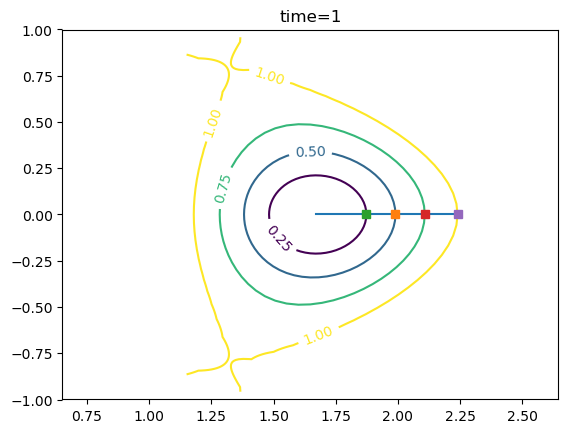

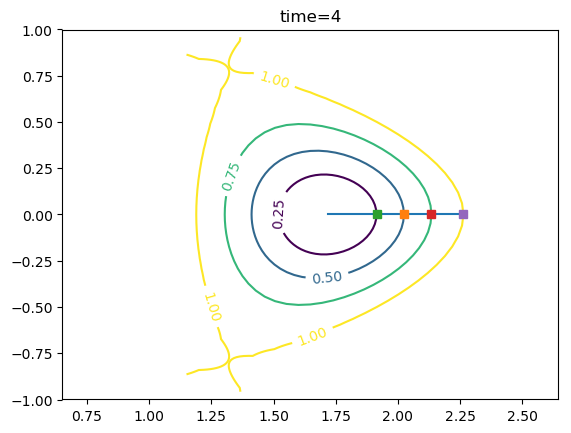

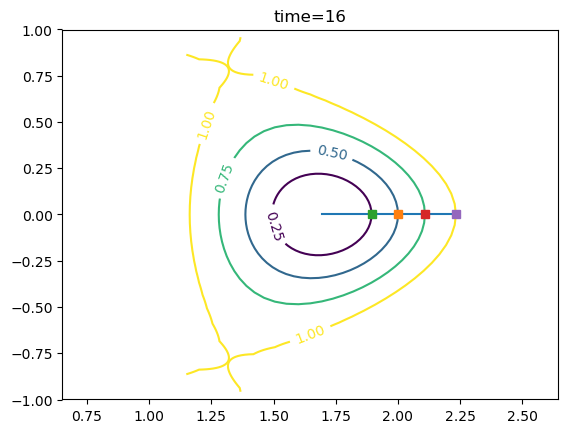

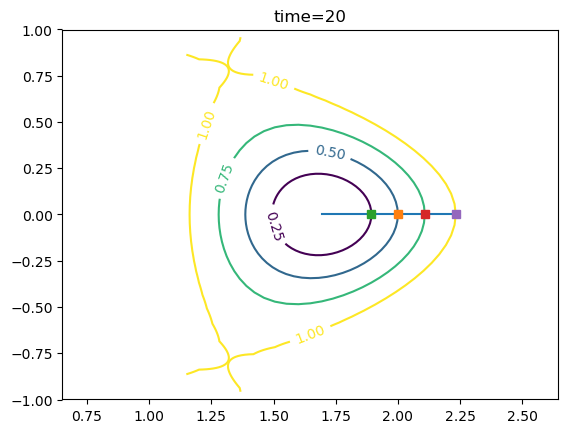

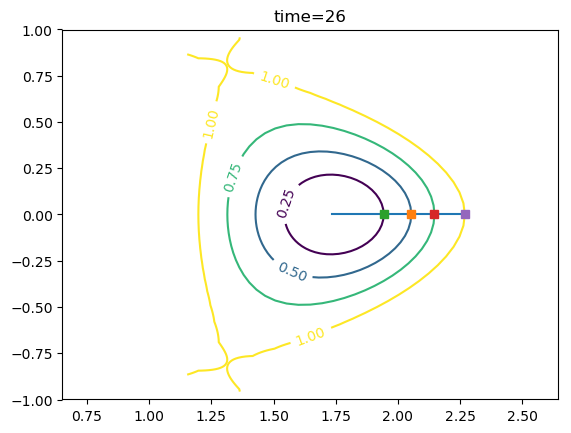

In [41]:
for t = [1,4,16,20,26]
    PyPlot.figure()
    PyPlot.title("time=$t")
    CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.25,0.5,0.75,1.0])
    PyPlot.clabel(CS,fmt="%1.2f")
    PyPlot.plot(X_eint(r_of_psi[t,:],0,0),Z_eint(r_of_psi[t,:],0,0))
    PyPlot.plot(X_eint(r_of_psi[t,51],0,0),Z_eint(r_of_psi[t,51],0,0),"s")
    PyPlot.plot(X_eint(r_of_psi[t,26],0,0),Z_eint(r_of_psi[t,26],0,0),"s")
    PyPlot.plot(X_eint(r_of_psi[t,76],0,0),Z_eint(r_of_psi[t,76],0,0),"s")
    PyPlot.plot(X_eint(r_of_psi[t,101],0,0),Z_eint(r_of_psi[t,101],0,0),"s")
    PyPlot.show()
end

Plotting of the solution of the integration around the flux surface along with the flux surfaces.

(t, u) = ([0.18918862657519886, 0.08637663974286873, -0.13398935828708256], 0.01637920360693057)
(t, u) = ([0.1888135380728367, 0.11184694013531186, -0.17350191654868063], 0.021208052308712963)
(t, u) = ([0.18841789684836965, 0.13319791285805913, -0.20662814562569476], 0.025254744246318062)
(t, u) = ([0.18687244203139985, 0.1962059296846442, -0.30440943719690894], 0.037182349048239915)
(t, u) = ([0.1844931222005947, 0.2669058092902545, -0.41418237146641657], 0.05052957266482282)
(t, u) = ([0.18313529675263518, 0.3001355097640638, -0.46580862416162916], 0.05678734283610502)
(t, u) = ([0.1821633117407663, 0.3219279628232963, -0.49968130133575245], 0.060884835206643145)
(t, u) = ([0.1789118551725224, 0.38660144198769203, -0.6003037986525155], 0.07300905732855094)
(t, u) = ([0.17565985497964728, 0.4427019535481141, -0.6877560830708065], 0.08347554352370942)
(t, u) = ([0.1724536311546546, 0.4923752023141007, -0.7653755457588579], 0.09269855639165399)
(t, u) = ([0.1680450260286548, 0.5541685

(t, u) = ([0.007810953515921087, 2.14401379889891, -2.7271121241307013], 0.31413320734465205)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.727112124096935], 0.3141332073562097)


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /users/giannis_kx/.julia/packages/DiffEqBase/b38LC/src/integrator_interface.jl:329


(t, u) = ([0.007810953527897726, 2.14401379889891, -2.7271121240047687], 0.31413320736607786)
(t, u) = ([0.007810953520323544, 2.14401379889891, -2.72711212408441], 0.314133207373652)
(t, u) = ([0.007810953515804639, 2.14401379889891, -2.7271121241319256], 0.3141332073857652)
(t, u) = ([0.007810953516855251, 2.14401379889891, -2.7271121241208784], 0.31413320739431755)
(t, u) = ([0.007810953519312766, 2.14401379889891, -2.7271121240950382], 0.3141332074031623)
(t, u) = ([0.007810953510864479, 2.14401379889891, -2.7271121241838707], 0.31413320741267353)
(t, u) = ([0.007810953518099077, 2.14401379889891, -2.7271121241078], 0.31413320741990813)
(t, u) = ([0.007810953523811502, 2.14401379889891, -2.7271121240477347], 0.31413320743522066)
(t, u) = ([0.007810953522507394, 2.14401379889891, -2.7271121240614473], 0.31413320744583656)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.7271121240933183], 0.31413320745674544)
(t, u) = ([0.0078109535102154435, 2.14401379889891, -2.72711212419069

(t, u) = ([0.007810953528394556, 2.14401379889891, -2.727112123999544], 0.31413320852204496)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.7271121240831135], 0.3141332085299927)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.72711212413816], 0.3141332085440259)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.7271121241255076], 0.314133208553821)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.31413320856391047)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.31413320857471466)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.727112124081183], 0.3141332085828994)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.7271121241452536], 0.314133208599233)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307], 0.3141332086105001)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.7271121240969336], 0.31413320862205774)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047673], 0.3

(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.7271121241838703], 0.31413320952242035)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.7271121241077996], 0.31413320952965496)
(t, u) = ([0.007810953523811503, 2.14401379889891, -2.7271121240477343], 0.3141332095449675)
(t, u) = ([0.007810953522507395, 2.14401379889891, -2.727112124061447], 0.3141332095555834)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.727112124093318], 0.31413320956649227)
(t, u) = ([0.007810953510215442, 2.14401379889891, -2.727112124190695], 0.31413320957691837)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.7271121241071254], 0.3141332095848661)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.727112124052079], 0.3141332095988993)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.7271121240647314], 0.3141332096086944)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.7271121240942082], 0.3141332096187839)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.7271121241951

(t, u) = ([0.007810953520630315, 2.14401379889891, -2.7271121240811835], 0.3141332106926462)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.727112124145254], 0.3141332107089798)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307004], 0.3141332107202469)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.727112124096934], 0.31413321073180456)
(t, u) = ([0.007810953527897734, 2.14401379889891, -2.7271121240047678], 0.3141332107416727)
(t, u) = ([0.007810953520323544, 2.14401379889891, -2.7271121240844094], 0.3141332107492469)
(t, u) = ([0.0078109535158046375, 2.14401379889891, -2.727112124131925], 0.31413321076136014)
(t, u) = ([0.007810953516855249, 2.14401379889891, -2.727112124120878], 0.31413321076991246)
(t, u) = ([0.007810953519312765, 2.14401379889891, -2.727112124095038], 0.3141332107787572)
(t, u) = ([0.007810953510864475, 2.14401379889891, -2.7271121241838703], 0.31413321078826845)
(t, u) = ([0.007810953518099076, 2.14401379889891, -2.7271121241077996

(t, u) = ([0.007810953519391714, 2.14401379889891, -2.7271121240942073], 0.3141332117285307)
(t, u) = ([0.007810953509794953, 2.14401379889891, -2.727112124195116], 0.3141332117393349)
(t, u) = ([0.0078109535179796815, 2.14401379889891, -2.727112124109055], 0.3141332117475196)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.7271121240449845], 0.3141332117638532)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.727112124059538], 0.3141332117751203)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.7271121240933045], 0.31413321178667797)
(t, u) = ([0.007810953510712262, 2.14401379889891, -2.7271121241854708], 0.31413321179654613)
(t, u) = ([0.007810953518286453, 2.14401379889891, -2.727112124105829], 0.3141332118041203)
(t, u) = ([0.007810953522805359, 2.14401379889891, -2.7271121240583134], 0.31413321181623355)
(t, u) = ([0.007810953521754747, 2.14401379889891, -2.7271121240693605], 0.3141332118247859)
(t, u) = ([0.007810953519297231, 2.14401379889891, -2.727112124095200

(t, u) = ([0.007810953519312766, 2.14401379889891, -2.7271121240950373], 0.31413321288850404)
(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.72711212418387], 0.31413321289801527)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.727112124107799], 0.31413321290524987)
(t, u) = ([0.007810953523811503, 2.14401379889891, -2.727112124047734], 0.3141332129205624)
(t, u) = ([0.007810953522507395, 2.14401379889891, -2.7271121240614464], 0.3141332129311783)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.7271121240933174], 0.3141332129420872)
(t, u) = ([0.007810953510215442, 2.14401379889891, -2.7271121241906946], 0.3141332129525133)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.727112124107125], 0.31413321296046104)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.7271121240520784], 0.3141332129744942)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.727112124064731], 0.3141332129842893)
(t, u) = ([0.007810953519391714, 2.14401379889891, -2.727112124094208]

(t, u) = ([0.007810953516414917, 2.14401379889891, -2.7271121241255076], 0.3141332140391627)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.3141332140492522)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.3141332140600564)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.727112124081183], 0.31413321406824113)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.7271121241452536], 0.31413321408457473)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307], 0.31413321409584183)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.7271121240969336], 0.31413321410739947)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047673], 0.31413321411726763)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.727112124084409], 0.3141332141248418)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.7271121241319247], 0.31413321413695505)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.727112124120877

(t, u) = ([0.007810953519297232, 2.14401379889891, -2.7271121240952017], 0.31413321520922555)
(t, u) = ([0.0078109535277455224, 2.14401379889891, -2.727112124006369], 0.31413321521873677)
(t, u) = ([0.0078109535205109215, 2.14401379889891, -2.72711212408244], 0.3141332152259714)
(t, u) = ([0.007810953514798495, 2.14401379889891, -2.727112124142505], 0.3141332152412839)
(t, u) = ([0.007810953516102603, 2.14401379889891, -2.7271121241287926], 0.3141332152518998)
(t, u) = ([0.007810953519133633, 2.14401379889891, -2.7271121240969216], 0.3141332152628087)
(t, u) = ([0.007810953528394556, 2.14401379889891, -2.7271121239995444], 0.3141332152732348)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.727112124083114], 0.31413321528118254)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.7271121241381606], 0.3141332152952157)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.727112124125508], 0.3141332153050108)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.727112124096031], 

(t, u) = ([0.0078109535233983635, 2.14401379889891, -2.7271121240520784], 0.3141332163500891)
(t, u) = ([0.00781095352219508, 2.14401379889891, -2.727112124064731], 0.3141332163598842)
(t, u) = ([0.007810953519391714, 2.14401379889891, -2.727112124094208], 0.3141332163699737)
(t, u) = ([0.007810953509794953, 2.14401379889891, -2.7271121241951164], 0.3141332163807779)
(t, u) = ([0.0078109535179796815, 2.14401379889891, -2.7271121241090555], 0.31413321638896263)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.31413321640529623)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595386], 0.31413321641656333)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.314133216428121)
(t, u) = ([0.007810953510712262, 2.14401379889891, -2.727112124185471], 0.31413321643798914)
(t, u) = ([0.007810953518286453, 2.14401379889891, -2.7271121241058296], 0.3141332164455633)
(t, u) = ([0.007810953522805359, 2.14401379889891, -2.727112124058314]

(t, u) = ([0.0078109535158046375, 2.14401379889891, -2.7271121241319247], 0.31413321751254997)
(t, u) = ([0.007810953516855249, 2.14401379889891, -2.7271121241208776], 0.3141332175211023)
(t, u) = ([0.007810953519312765, 2.14401379889891, -2.7271121240950373], 0.31413321752994705)
(t, u) = ([0.007810953510864475, 2.14401379889891, -2.72711212418387], 0.3141332175394583)
(t, u) = ([0.007810953518099076, 2.14401379889891, -2.727112124107799], 0.3141332175466929)
(t, u) = ([0.007810953523811502, 2.14401379889891, -2.727112124047734], 0.3141332175620054)
(t, u) = ([0.007810953522507394, 2.14401379889891, -2.7271121240614464], 0.3141332175726213)
(t, u) = ([0.0078109535194763645, 2.14401379889891, -2.7271121240933174], 0.3141332175835302)
(t, u) = ([0.007810953510215441, 2.14401379889891, -2.7271121241906946], 0.3141332175939563)
(t, u) = ([0.007810953518163217, 2.14401379889891, -2.727112124107125], 0.31413321760190405)
(t, u) = ([0.0078109535233983635, 2.14401379889891, -2.727112124052078

(t, u) = ([0.007810953520510921, 2.14401379889891, -2.727112124082439], 0.3141332186015663)
(t, u) = ([0.0078109535147984945, 2.14401379889891, -2.7271121241425043], 0.3141332186168788)
(t, u) = ([0.007810953516102602, 2.14401379889891, -2.7271121241287917], 0.3141332186274947)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.7271121240969207], 0.3141332186384036)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.7271121239995435], 0.3141332186488297)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.727112124083113], 0.31413321865677746)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.7271121241381597], 0.3141332186708106)
(t, u) = ([0.007810953516414916, 2.14401379889891, -2.727112124125507], 0.31413321868060573)
(t, u) = ([0.007810953519218282, 2.14401379889891, -2.7271121240960303], 0.3141332186906952)
(t, u) = ([0.007810953528815044, 2.14401379889891, -2.7271121239951217], 0.3141332187014994)
(t, u) = ([0.007810953520630315, 2.14401379889891, -2.7271121240811826

(t, u) = ([0.007810953517979682, 2.14401379889891, -2.7271121241090555], 0.31413321976455755)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.31413321978089115)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595386], 0.31413321979215825)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.3141332198037159)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.727112124185471], 0.31413321981358405)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.7271121241058296], 0.3141332198211582)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.727112124058314], 0.31413321983327147)
(t, u) = ([0.007810953521754748, 2.14401379889891, -2.727112124069361], 0.3141332198418238)
(t, u) = ([0.007810953519297232, 2.14401379889891, -2.727112124095201], 0.31413321985066855)
(t, u) = ([0.0078109535277455224, 2.14401379889891, -2.7271121240063687], 0.3141332198601798)
(t, u) = ([0.0078109535205109215, 2.14401379889891, -2.7271121240824

(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131925], 0.3141332208881449)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.727112124120878], 0.3141332208966972)
(t, u) = ([0.007810953519312766, 2.14401379889891, -2.727112124095038], 0.31413322090554197)
(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.7271121241838703], 0.3141332209150532)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.7271121241077996], 0.3141332209222878)
(t, u) = ([0.007810953523811503, 2.14401379889891, -2.7271121240477343], 0.3141332209376003)
(t, u) = ([0.007810953522507395, 2.14401379889891, -2.727112124061447], 0.3141332209482162)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.727112124093318], 0.3141332209591251)
(t, u) = ([0.007810953510215442, 2.14401379889891, -2.727112124190695], 0.3141332209695512)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.7271121241071254], 0.31413322097749896)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.727112124052079], 0

(t, u) = ([0.007810953515211634, 2.14401379889891, -2.72711212413816], 0.31413322204640554)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.7271121241255076], 0.31413322205620064)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.31413322206629013)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.3141332220770943)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.7271121240811835], 0.31413322208527905)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.727112124145254], 0.31413322210161265)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307004], 0.31413322211287975)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.727112124096934], 0.3141332221244374)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047678], 0.31413322213430556)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.7271121240844094], 0.3141332221418797)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131

(t, u) = ([0.007810953522805359, 2.14401379889891, -2.7271121240583134], 0.3141332232088664)
(t, u) = ([0.007810953521754747, 2.14401379889891, -2.7271121240693605], 0.3141332232174187)
(t, u) = ([0.007810953519297231, 2.14401379889891, -2.7271121240952008], 0.31413322322626347)
(t, u) = ([0.007810953527745522, 2.14401379889891, -2.7271121240063683], 0.3141332232357747)
(t, u) = ([0.007810953520510921, 2.14401379889891, -2.727112124082439], 0.3141332232430093)
(t, u) = ([0.0078109535147984945, 2.14401379889891, -2.7271121241425043], 0.3141332232583218)
(t, u) = ([0.007810953516102602, 2.14401379889891, -2.7271121241287917], 0.3141332232689377)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.7271121240969207], 0.3141332232798466)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.7271121239995435], 0.3141332232902727)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.727112124083113], 0.31413322329822047)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.727112124138159

(t, u) = ([0.007810953523398364, 2.14401379889891, -2.7271121240520784], 0.31413322436712704)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.727112124064731], 0.31413322437692215)
(t, u) = ([0.007810953519391714, 2.14401379889891, -2.727112124094208], 0.31413322438701163)
(t, u) = ([0.007810953509794953, 2.14401379889891, -2.7271121241951164], 0.3141332243978158)
(t, u) = ([0.0078109535179796815, 2.14401379889891, -2.727112124109055], 0.31413322440600056)
(t, u) = ([0.0078109535240730174, 2.14401379889891, -2.7271121240449845], 0.31413322442233416)
(t, u) = ([0.007810953522688914, 2.14401379889891, -2.727112124059538], 0.31413322443360125)
(t, u) = ([0.007810953519477624, 2.14401379889891, -2.7271121240933045], 0.3141332244451589)
(t, u) = ([0.007810953510712262, 2.14401379889891, -2.7271121241854708], 0.31413322445502706)
(t, u) = ([0.007810953518286453, 2.14401379889891, -2.727112124105829], 0.3141332244626012)
(t, u) = ([0.007810953522805359, 2.14401379889891, -2.727112124058

(t, u) = ([0.007810953516855249, 2.14401379889891, -2.7271121241208776], 0.3141332255381402)
(t, u) = ([0.007810953519312765, 2.14401379889891, -2.7271121240950373], 0.314133225546985)
(t, u) = ([0.007810953510864475, 2.14401379889891, -2.72711212418387], 0.3141332255564962)
(t, u) = ([0.007810953518099076, 2.14401379889891, -2.727112124107799], 0.3141332255637308)
(t, u) = ([0.007810953523811502, 2.14401379889891, -2.727112124047734], 0.31413322557904333)
(t, u) = ([0.007810953522507394, 2.14401379889891, -2.7271121240614464], 0.3141332255896592)
(t, u) = ([0.0078109535194763645, 2.14401379889891, -2.7271121240933174], 0.3141332256005681)
(t, u) = ([0.007810953510215441, 2.14401379889891, -2.7271121241906946], 0.3141332256109942)
(t, u) = ([0.007810953518163217, 2.14401379889891, -2.727112124107125], 0.31413322561894197)
(t, u) = ([0.0078109535233983635, 2.14401379889891, -2.7271121240520784], 0.31413322563297513)
(t, u) = ([0.00781095352219508, 2.14401379889891, -2.727112124064731], 

(t, u) = ([0.007810953520630316, 2.14401379889891, -2.7271121240811835], 0.31413322672672206)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.727112124145254], 0.31413322674305566)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307004], 0.31413322675432276)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.727112124096934], 0.3141332267658804)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047678], 0.31413322677574856)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.7271121240844094], 0.3141332267833227)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131925], 0.314133226795436)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.727112124120878], 0.3141332268039883)
(t, u) = ([0.007810953519312766, 2.14401379889891, -2.727112124095038], 0.31413322681283307)
(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.7271121241838703], 0.3141332268223443)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.727112124107799

(t, u) = ([0.007810953522805359, 2.14401379889891, -2.727112124058314], 0.3141332278503094)
(t, u) = ([0.007810953521754747, 2.14401379889891, -2.727112124069361], 0.3141332278588617)
(t, u) = ([0.007810953519297231, 2.14401379889891, -2.727112124095201], 0.3141332278677065)
(t, u) = ([0.007810953527745522, 2.14401379889891, -2.7271121240063687], 0.3141332278772177)
(t, u) = ([0.007810953520510921, 2.14401379889891, -2.7271121240824394], 0.3141332278844523)
(t, u) = ([0.0078109535147984945, 2.14401379889891, -2.7271121241425047], 0.31413322789976483)
(t, u) = ([0.007810953516102602, 2.14401379889891, -2.727112124128792], 0.31413322791038073)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.727112124096921], 0.3141332279212896)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.727112123999544], 0.3141332279317157)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.7271121240831135], 0.3141332279396635)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.72711212413816], 0.

(t, u) = ([0.007810953523398364, 2.14401379889891, -2.7271121240520784], 0.31413322900857005)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.727112124064731], 0.31413322901836516)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.727112124094208], 0.31413322902845464)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.7271121241951164], 0.31413322903925883)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.7271121241090555], 0.31413322904744356)
(t, u) = ([0.007810953524073019, 2.14401379889891, -2.727112124044985], 0.31413322906377716)
(t, u) = ([0.007810953522688915, 2.14401379889891, -2.7271121240595386], 0.31413322907504426)
(t, u) = ([0.007810953519477626, 2.14401379889891, -2.727112124093305], 0.3141332290866019)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.727112124185471], 0.31413322909647007)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.7271121241058296], 0.31413322910404423)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.72711212405

(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047673], 0.3141332301513435)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.727112124084409], 0.31413323015891764)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.7271121241319247], 0.3141332301710309)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.7271121241208776], 0.3141332301795832)
(t, u) = ([0.007810953519312766, 2.14401379889891, -2.7271121240950373], 0.314133230188428)
(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.72711212418387], 0.3141332301979392)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.727112124107799], 0.3141332302051738)
(t, u) = ([0.007810953523811503, 2.14401379889891, -2.727112124047734], 0.31413323022048634)
(t, u) = ([0.007810953522507395, 2.14401379889891, -2.7271121240614464], 0.31413323023110223)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.7271121240933174], 0.3141332302420111)
(t, u) = ([0.007810953510215442, 2.14401379889891, -2.7271121241906946]

(t, u) = ([0.007810953528394556, 2.14401379889891, -2.727112123999544], 0.31413323130731063)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.7271121240831135], 0.3141332313152584)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.72711212413816], 0.31413323132929155)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.7271121241255076], 0.31413323133908666)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.31413323134917615)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.31413323135998034)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.727112124081183], 0.31413323136816507)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.7271121241452536], 0.31413323138449867)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307], 0.31413323139576577)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.7271121240969336], 0.3141332314073234)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047673

(t, u) = ([0.007810953522805359, 2.14401379889891, -2.727112124058314], 0.3141332324917524)
(t, u) = ([0.007810953521754747, 2.14401379889891, -2.727112124069361], 0.3141332325003047)
(t, u) = ([0.007810953519297231, 2.14401379889891, -2.727112124095201], 0.3141332325091495)
(t, u) = ([0.007810953527745522, 2.14401379889891, -2.7271121240063687], 0.3141332325186607)
(t, u) = ([0.007810953520510921, 2.14401379889891, -2.7271121240824394], 0.3141332325258953)
(t, u) = ([0.0078109535147984945, 2.14401379889891, -2.7271121241425047], 0.31413323254120784)
(t, u) = ([0.007810953516102602, 2.14401379889891, -2.727112124128792], 0.31413323255182374)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.727112124096921], 0.3141332325627326)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.727112123999544], 0.3141332325731587)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.7271121240831135], 0.3141332325811065)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.72711212413816], 0.

(t, u) = ([0.0078109535233983635, 2.14401379889891, -2.7271121240520784], 0.31413323365001306)
(t, u) = ([0.00781095352219508, 2.14401379889891, -2.727112124064731], 0.31413323365980816)
(t, u) = ([0.007810953519391714, 2.14401379889891, -2.727112124094208], 0.31413323366989765)
(t, u) = ([0.007810953509794953, 2.14401379889891, -2.7271121241951164], 0.31413323368070184)
(t, u) = ([0.0078109535179796815, 2.14401379889891, -2.7271121241090555], 0.31413323368888657)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.31413323370522017)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595386], 0.31413323371648727)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.3141332337280449)
(t, u) = ([0.007810953510712262, 2.14401379889891, -2.727112124185471], 0.3141332337379131)
(t, u) = ([0.007810953518286453, 2.14401379889891, -2.7271121241058296], 0.31413323374548724)
(t, u) = ([0.007810953522805359, 2.14401379889891, -2.72711212405

(t, u) = ([0.007810953514536979, 2.14401379889891, -2.7271121241452536], 0.3141332347600936)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307], 0.3141332347713607)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.7271121240969336], 0.3141332347829183)
(t, u) = ([0.007810953527897734, 2.14401379889891, -2.7271121240047673], 0.3141332347927865)
(t, u) = ([0.007810953520323544, 2.14401379889891, -2.727112124084409], 0.31413323480036065)
(t, u) = ([0.0078109535158046375, 2.14401379889891, -2.7271121241319247], 0.3141332348124739)
(t, u) = ([0.007810953516855249, 2.14401379889891, -2.7271121241208776], 0.31413323482102623)
(t, u) = ([0.007810953519312765, 2.14401379889891, -2.7271121240950373], 0.314133234829871)
(t, u) = ([0.007810953510864475, 2.14401379889891, -2.72711212418387], 0.3141332348393822)
(t, u) = ([0.007810953518099076, 2.14401379889891, -2.727112124107799], 0.3141332348466168)
(t, u) = ([0.007810953523811502, 2.14401379889891, -2.727112124047734], 0.3

(t, u) = ([0.007810953516102603, 2.14401379889891, -2.7271121241287917], 0.31413323592741865)
(t, u) = ([0.007810953519133633, 2.14401379889891, -2.7271121240969207], 0.31413323593832754)
(t, u) = ([0.007810953528394556, 2.14401379889891, -2.7271121239995435], 0.31413323594875364)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.727112124083113], 0.3141332359567014)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.7271121241381597], 0.31413323597073456)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.727112124125507], 0.31413323598052967)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960303], 0.31413323599061915)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.7271121239951217], 0.31413323600142334)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.727112124081183], 0.3141332360096081)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.7271121241452536], 0.3141332360259417)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.727112124130

(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.3141332370808151)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595386], 0.3141332370920822)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.31413323710363983)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.727112124185471], 0.314133237113508)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.7271121241058296], 0.31413323712108215)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.727112124058314], 0.3141332371331954)
(t, u) = ([0.007810953521754748, 2.14401379889891, -2.727112124069361], 0.31413323714174773)
(t, u) = ([0.007810953519297232, 2.14401379889891, -2.727112124095201], 0.3141332371505925)
(t, u) = ([0.0078109535277455224, 2.14401379889891, -2.7271121240063687], 0.3141332371601037)
(t, u) = ([0.0078109535205109215, 2.14401379889891, -2.7271121240824394], 0.3141332371673383)
(t, u) = ([0.007810953514798495, 2.14401379889891, -2.7271121241425047]

(t, u) = ([0.007810953522507395, 2.14401379889891, -2.727112124061447], 0.31413323824814016)
(t, u) = ([0.007810953519476365, 2.14401379889891, -2.727112124093318], 0.31413323825904904)
(t, u) = ([0.007810953510215442, 2.14401379889891, -2.727112124190695], 0.31413323826947515)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.7271121241071254], 0.3141332382774229)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.727112124052079], 0.31413323829145606)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.7271121240647314], 0.31413323830125117)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.7271121240942082], 0.31413323831134066)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.727112124195117], 0.31413323832214485)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.7271121241090555], 0.3141332383303296)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.3141332383466632)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595

(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307004], 0.3141332394128037)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.727112124096934], 0.31413323942436133)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047678], 0.3141332394342295)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.7271121240844094], 0.31413323944180366)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131925], 0.3141332394539169)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.727112124120878], 0.31413323946246924)
(t, u) = ([0.007810953519312766, 2.14401379889891, -2.727112124095038], 0.314133239471314)
(t, u) = ([0.0078109535108644755, 2.14401379889891, -2.7271121241838703], 0.3141332394808252)
(t, u) = ([0.0078109535180990765, 2.14401379889891, -2.7271121241077996], 0.3141332394880598)
(t, u) = ([0.007810953523811503, 2.14401379889891, -2.7271121240477343], 0.31413323950337235)
(t, u) = ([0.007810953522507395, 2.14401379889891, -2.72711212406144

(t, u) = ([0.007810953519133633, 2.14401379889891, -2.7271121240969207], 0.31413324057977055)
(t, u) = ([0.007810953528394556, 2.14401379889891, -2.7271121239995435], 0.31413324059019665)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.727112124083113], 0.3141332405981444)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.7271121241381597], 0.31413324061217757)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.727112124125507], 0.3141332406219727)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960303], 0.31413324063206216)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.7271121239951217], 0.31413324064286635)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.727112124081183], 0.3141332406510511)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.7271121241452536], 0.3141332406673847)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307], 0.3141332406786518)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.7271121240969336]

(t, u) = ([0.007810953523398365, 2.14401379889891, -2.7271121240520784], 0.314133241667051)
(t, u) = ([0.007810953522195082, 2.14401379889891, -2.727112124064731], 0.3141332416768461)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.727112124094208], 0.31413324168693557)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.7271121241951164], 0.31413324169773976)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.727112124109055], 0.3141332417059245)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.7271121240449845], 0.3141332417222581)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.727112124059538], 0.3141332417335252)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.7271121240933045], 0.31413324174508284)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.7271121241854708], 0.314133241754951)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.727112124105829], 0.31413324176252516)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.7271121240583134]

(t, u) = ([0.007810953515804639, 2.14401379889891, -2.7271121241319247], 0.3141332428295118)
(t, u) = ([0.007810953516855251, 2.14401379889891, -2.7271121241208776], 0.31413324283806415)
(t, u) = ([0.007810953519312767, 2.14401379889891, -2.7271121240950373], 0.3141332428469089)
(t, u) = ([0.007810953510864476, 2.14401379889891, -2.72711212418387], 0.31413324285642014)
(t, u) = ([0.007810953518099077, 2.14401379889891, -2.727112124107799], 0.31413324286365474)
(t, u) = ([0.0078109535238115035, 2.14401379889891, -2.727112124047734], 0.31413324287896727)
(t, u) = ([0.007810953522507396, 2.14401379889891, -2.7271121240614464], 0.31413324288958316)
(t, u) = ([0.007810953519476366, 2.14401379889891, -2.7271121240933174], 0.31413324290049205)
(t, u) = ([0.007810953510215443, 2.14401379889891, -2.7271121241906946], 0.31413324291091815)
(t, u) = ([0.007810953518163219, 2.14401379889891, -2.727112124107125], 0.3141332429188659)
(t, u) = ([0.007810953523398365, 2.14401379889891, -2.7271121240520

(t, u) = ([0.007810953516414917, 2.14401379889891, -2.727112124125508], 0.3141332439975676)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.727112124096031], 0.3141332440076571)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.7271121239951226], 0.31413324401846127)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.7271121240811835], 0.314133244026646)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.727112124145254], 0.3141332440429796)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307004], 0.3141332440542467)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.727112124096934], 0.31413324406580434)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047678], 0.3141332440756725)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.7271121240844094], 0.31413324408324667)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131925], 0.3141332440953599)
(t, u) = ([0.00781095351685525, 2.14401379889891, -2.727112124120878], 

(t, u) = ([0.007810953516102602, 2.14401379889891, -2.727112124128792], 0.31413324521030467)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.727112124096921], 0.31413324522121355)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.727112123999544], 0.31413324523163966)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.7271121240831135], 0.3141332452395874)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.72711212413816], 0.3141332452536206)
(t, u) = ([0.007810953516414916, 2.14401379889891, -2.7271121241255076], 0.3141332452634157)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.31413324527350517)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.31413324528430936)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.7271121240811835], 0.3141332452924941)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.727112124145254], 0.3141332453088277)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307004]

(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.31413324638652584)
(t, u) = ([0.007810953510712262, 2.14401379889891, -2.727112124185471], 0.314133246396394)
(t, u) = ([0.007810953518286453, 2.14401379889891, -2.7271121241058296], 0.31413324640396817)
(t, u) = ([0.007810953522805359, 2.14401379889891, -2.727112124058314], 0.3141332464160814)
(t, u) = ([0.007810953521754747, 2.14401379889891, -2.727112124069361], 0.31413324642463375)
(t, u) = ([0.007810953519297231, 2.14401379889891, -2.727112124095201], 0.3141332464334785)
(t, u) = ([0.007810953527745522, 2.14401379889891, -2.7271121240063687], 0.31413324644298973)
(t, u) = ([0.007810953520510921, 2.14401379889891, -2.7271121240824394], 0.31413324645022433)
(t, u) = ([0.0078109535147984945, 2.14401379889891, -2.7271121241425047], 0.31413324646553686)
(t, u) = ([0.007810953516102602, 2.14401379889891, -2.727112124128792], 0.31413324647615276)
(t, u) = ([0.007810953519133632, 2.14401379889891, -2.727112124096921

(t, u) = ([0.007810953510215442, 2.14401379889891, -2.727112124190694], 0.31413324755236116)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.7271121241071246], 0.3141332475603089)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.727112124052078], 0.3141332475743421)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.7271121240647305], 0.3141332475841372)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.7271121240942073], 0.31413324759422667)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.727112124195116], 0.31413324760503086)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.727112124109055], 0.3141332476132156)
(t, u) = ([0.007810953524073019, 2.14401379889891, -2.7271121240449845], 0.3141332476295492)
(t, u) = ([0.007810953522688915, 2.14401379889891, -2.727112124059538], 0.3141332476408163)
(t, u) = ([0.007810953519477626, 2.14401379889891, -2.7271121240933045], 0.31413324765237394)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.7271121241854708

(t, u) = ([0.00781095351453698, 2.14401379889891, -2.7271121241452536], 0.3141332486844226)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307], 0.3141332486956897)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.7271121240969336], 0.31413324870724735)
(t, u) = ([0.007810953527897736, 2.14401379889891, -2.7271121240047673], 0.3141332487171155)
(t, u) = ([0.007810953520323545, 2.14401379889891, -2.727112124084409], 0.3141332487246897)
(t, u) = ([0.007810953515804639, 2.14401379889891, -2.7271121241319247], 0.31413324873680293)
(t, u) = ([0.007810953516855251, 2.14401379889891, -2.7271121241208776], 0.31413324874535525)
(t, u) = ([0.007810953519312767, 2.14401379889891, -2.7271121240950373], 0.3141332487542)
(t, u) = ([0.007810953510864476, 2.14401379889891, -2.72711212418387], 0.31413324876371124)
(t, u) = ([0.007810953518099077, 2.14401379889891, -2.727112124107799], 0.31413324877094584)
(t, u) = ([0.0078109535238115035, 2.14401379889891, -2.727112124047734], 0.

(t, u) = ([0.007810953516102604, 2.14401379889891, -2.727112124128792], 0.3141332498517477)
(t, u) = ([0.0078109535191336335, 2.14401379889891, -2.727112124096921], 0.31413324986265656)
(t, u) = ([0.007810953528394557, 2.14401379889891, -2.727112123999544], 0.31413324987308267)
(t, u) = ([0.007810953520446781, 2.14401379889891, -2.7271121240831135], 0.3141332498810304)
(t, u) = ([0.0078109535152116345, 2.14401379889891, -2.72711212413816], 0.3141332498950636)
(t, u) = ([0.007810953516414918, 2.14401379889891, -2.7271121241255076], 0.3141332499048587)
(t, u) = ([0.007810953519218284, 2.14401379889891, -2.7271121240960308], 0.3141332499149482)
(t, u) = ([0.007810953528815045, 2.14401379889891, -2.727112123995122], 0.31413324992575237)
(t, u) = ([0.0078109535206303165, 2.14401379889891, -2.727112124081183], 0.3141332499339371)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.7271121241452536], 0.3141332499502707)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307], 0

(t, u) = ([0.007810953510215442, 2.14401379889891, -2.727112124190695], 0.3141332509279561)
(t, u) = ([0.007810953518163218, 2.14401379889891, -2.7271121241071254], 0.31413325093590383)
(t, u) = ([0.007810953523398364, 2.14401379889891, -2.727112124052079], 0.314133250949937)
(t, u) = ([0.007810953522195081, 2.14401379889891, -2.7271121240647314], 0.3141332509597321)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.7271121240942082], 0.3141332509698216)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.727112124195117], 0.3141332509806258)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.727112124109056], 0.3141332509888105)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.7271121240449854], 0.3141332510051441)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.727112124059539], 0.3141332510164112)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.7271121240933054], 0.31413325102796885)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.7271121241854717],

(t, u) = ([0.0078109535158046375, 2.14401379889891, -2.7271121241319247], 0.31413325211239784)
(t, u) = ([0.007810953516855249, 2.14401379889891, -2.7271121241208776], 0.31413325212095017)
(t, u) = ([0.007810953519312765, 2.14401379889891, -2.7271121240950373], 0.3141332521297949)
(t, u) = ([0.007810953510864475, 2.14401379889891, -2.72711212418387], 0.31413325213930615)
(t, u) = ([0.007810953518099076, 2.14401379889891, -2.727112124107799], 0.31413325214654075)
(t, u) = ([0.007810953523811502, 2.14401379889891, -2.727112124047734], 0.3141332521618533)
(t, u) = ([0.007810953522507394, 2.14401379889891, -2.7271121240614464], 0.3141332521724692)
(t, u) = ([0.0078109535194763645, 2.14401379889891, -2.7271121240933174], 0.31413325218337806)
(t, u) = ([0.007810953510215441, 2.14401379889891, -2.7271121241906946], 0.31413325219380417)
(t, u) = ([0.007810953518163217, 2.14401379889891, -2.727112124107125], 0.3141332522017519)
(t, u) = ([0.0078109535233983635, 2.14401379889891, -2.727112124052

(t, u) = ([0.007810953519133632, 2.14401379889891, -2.7271121240969207], 0.3141332532382515)
(t, u) = ([0.007810953528394555, 2.14401379889891, -2.7271121239995435], 0.3141332532486776)
(t, u) = ([0.007810953520446779, 2.14401379889891, -2.727112124083113], 0.31413325325662533)
(t, u) = ([0.007810953515211633, 2.14401379889891, -2.7271121241381597], 0.3141332532706585)
(t, u) = ([0.007810953516414916, 2.14401379889891, -2.727112124125507], 0.3141332532804536)
(t, u) = ([0.007810953519218282, 2.14401379889891, -2.7271121240960303], 0.3141332532905431)
(t, u) = ([0.007810953528815044, 2.14401379889891, -2.7271121239951217], 0.3141332533013473)
(t, u) = ([0.007810953520630315, 2.14401379889891, -2.727112124081183], 0.314133253309532)
(t, u) = ([0.007810953514536979, 2.14401379889891, -2.7271121241452536], 0.3141332533258656)
(t, u) = ([0.007810953515921083, 2.14401379889891, -2.7271121241307], 0.3141332533371327)
(t, u) = ([0.007810953519132372, 2.14401379889891, -2.7271121240969336], 0.3

(t, u) = ([0.007810953510712263, 2.14401379889891, -2.7271121241854708], 0.31413325441343193)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.727112124105829], 0.3141332544210061)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.7271121240583134], 0.31413325443311935)
(t, u) = ([0.007810953521754748, 2.14401379889891, -2.7271121240693605], 0.31413325444167167)
(t, u) = ([0.007810953519297232, 2.14401379889891, -2.7271121240952008], 0.31413325445051643)
(t, u) = ([0.0078109535277455224, 2.14401379889891, -2.7271121240063683], 0.31413325446002766)
(t, u) = ([0.0078109535205109215, 2.14401379889891, -2.727112124082439], 0.31413325446726226)
(t, u) = ([0.007810953514798495, 2.14401379889891, -2.7271121241425043], 0.3141332544825748)
(t, u) = ([0.007810953516102603, 2.14401379889891, -2.7271121241287917], 0.3141332544931907)
(t, u) = ([0.007810953519133633, 2.14401379889891, -2.7271121240969207], 0.31413325450409957)
(t, u) = ([0.007810953528394556, 2.14401379889891, -2.727112123

(t, u) = ([0.007810953510215443, 2.14401379889891, -2.727112124190695], 0.3141332555693991)
(t, u) = ([0.007810953518163219, 2.14401379889891, -2.7271121241071254], 0.31413325557734684)
(t, u) = ([0.007810953523398365, 2.14401379889891, -2.727112124052079], 0.31413325559138)
(t, u) = ([0.007810953522195082, 2.14401379889891, -2.7271121240647314], 0.3141332556011751)
(t, u) = ([0.007810953519391716, 2.14401379889891, -2.7271121240942082], 0.3141332556112646)
(t, u) = ([0.007810953509794954, 2.14401379889891, -2.727112124195117], 0.3141332556220688)
(t, u) = ([0.007810953517979683, 2.14401379889891, -2.7271121241090555], 0.3141332556302535)
(t, u) = ([0.007810953524073019, 2.14401379889891, -2.727112124044985], 0.3141332556465871)
(t, u) = ([0.007810953522688915, 2.14401379889891, -2.7271121240595386], 0.3141332556578542)
(t, u) = ([0.007810953519477626, 2.14401379889891, -2.727112124093305], 0.31413325566941186)
(t, u) = ([0.007810953510712264, 2.14401379889891, -2.727112124185471], 0.3

(t, u) = ([0.007810953527897736, 2.14401379889891, -2.7271121240047678], 0.31413325673415343)
(t, u) = ([0.007810953520323545, 2.14401379889891, -2.7271121240844094], 0.3141332567417276)
(t, u) = ([0.007810953515804639, 2.14401379889891, -2.727112124131925], 0.31413325675384085)
(t, u) = ([0.007810953516855251, 2.14401379889891, -2.727112124120878], 0.3141332567623932)
(t, u) = ([0.007810953519312767, 2.14401379889891, -2.727112124095038], 0.31413325677123793)
(t, u) = ([0.007810953510864476, 2.14401379889891, -2.7271121241838703], 0.31413325678074916)
(t, u) = ([0.007810953518099077, 2.14401379889891, -2.7271121241077996], 0.31413325678798376)
(t, u) = ([0.0078109535238115035, 2.14401379889891, -2.7271121240477343], 0.3141332568032963)
(t, u) = ([0.007810953522507396, 2.14401379889891, -2.727112124061447], 0.3141332568139122)
(t, u) = ([0.007810953519476366, 2.14401379889891, -2.727112124093318], 0.31413325682482107)
(t, u) = ([0.007810953510215443, 2.14401379889891, -2.72711212419069

(t, u) = ([0.007810953515211634, 2.14401379889891, -2.72711212413816], 0.3141332579121015)
(t, u) = ([0.007810953516414917, 2.14401379889891, -2.7271121241255076], 0.3141332579218966)
(t, u) = ([0.007810953519218283, 2.14401379889891, -2.7271121240960308], 0.3141332579319861)
(t, u) = ([0.0078109535288150445, 2.14401379889891, -2.727112123995122], 0.3141332579427903)
(t, u) = ([0.007810953520630316, 2.14401379889891, -2.7271121240811835], 0.314133257950975)
(t, u) = ([0.00781095351453698, 2.14401379889891, -2.727112124145254], 0.3141332579673086)
(t, u) = ([0.0078109535159210835, 2.14401379889891, -2.7271121241307004], 0.3141332579785757)
(t, u) = ([0.007810953519132373, 2.14401379889891, -2.727112124096934], 0.31413325799013336)
(t, u) = ([0.007810953527897735, 2.14401379889891, -2.7271121240047678], 0.3141332580000015)
(t, u) = ([0.0078109535203235445, 2.14401379889891, -2.7271121240844094], 0.3141332580075757)
(t, u) = ([0.007810953515804638, 2.14401379889891, -2.727112124131925], 0

(t, u) = ([0.00781095352280536, 2.14401379889891, -2.727112124058314], 0.31413325907456235)
(t, u) = ([0.007810953521754748, 2.14401379889891, -2.727112124069361], 0.3141332590831147)
(t, u) = ([0.007810953519297232, 2.14401379889891, -2.727112124095201], 0.31413325909195944)
(t, u) = ([0.0078109535277455224, 2.14401379889891, -2.7271121240063687], 0.31413325910147066)
(t, u) = ([0.0078109535205109215, 2.14401379889891, -2.7271121240824394], 0.31413325910870527)
(t, u) = ([0.007810953514798495, 2.14401379889891, -2.7271121241425047], 0.3141332591240178)
(t, u) = ([0.007810953516102603, 2.14401379889891, -2.727112124128792], 0.3141332591346337)
(t, u) = ([0.007810953519133633, 2.14401379889891, -2.727112124096921], 0.3141332591455426)
(t, u) = ([0.007810953528394556, 2.14401379889891, -2.727112123999544], 0.3141332591559687)
(t, u) = ([0.00781095352044678, 2.14401379889891, -2.7271121240831135], 0.31413325916391643)
(t, u) = ([0.007810953515211634, 2.14401379889891, -2.72711212413816], 

(t, u) = ([0.007810953522195082, 2.14401379889891, -2.7271121240647314], 0.3141332602426181)
(t, u) = ([0.007810953519391715, 2.14401379889891, -2.7271121240942082], 0.3141332602527076)
(t, u) = ([0.0078109535097949535, 2.14401379889891, -2.727112124195117], 0.3141332602635118)
(t, u) = ([0.007810953517979682, 2.14401379889891, -2.7271121241090555], 0.3141332602716965)
(t, u) = ([0.007810953524073018, 2.14401379889891, -2.727112124044985], 0.3141332602880301)
(t, u) = ([0.0078109535226889145, 2.14401379889891, -2.7271121240595386], 0.3141332602992972)
(t, u) = ([0.007810953519477625, 2.14401379889891, -2.727112124093305], 0.31413326031085487)
(t, u) = ([0.007810953510712263, 2.14401379889891, -2.727112124185471], 0.31413326032072303)
(t, u) = ([0.0078109535182864535, 2.14401379889891, -2.7271121241058296], 0.3141332603282972)
(t, u) = ([0.00781095352280536, 2.14401379889891, -2.727112124058314], 0.31413326034041045)
(t, u) = ([0.007810953521754748, 2.14401379889891, -2.727112124069361]

(t, u) = ([0.007810953519312767, 2.14401379889891, -2.727112124095038], 0.31413326141268094)
(t, u) = ([0.007810953510864476, 2.14401379889891, -2.7271121241838703], 0.31413326142219217)
(t, u) = ([0.007810953518099077, 2.14401379889891, -2.7271121241077996], 0.31413326142942677)
(t, u) = ([0.0078109535238115035, 2.14401379889891, -2.7271121240477343], 0.3141332614447393)
(t, u) = ([0.007810953522507396, 2.14401379889891, -2.727112124061447], 0.3141332614553552)
(t, u) = ([0.007810953519476366, 2.14401379889891, -2.727112124093318], 0.3141332614662641)
(t, u) = ([0.007810953510215443, 2.14401379889891, -2.727112124190695], 0.3141332614766902)
(t, u) = ([0.007810953518163219, 2.14401379889891, -2.7271121241071254], 0.31413326148463794)
(t, u) = ([0.007810953523398365, 2.14401379889891, -2.727112124052079], 0.3141332614986711)
(t, u) = ([0.007810953522195082, 2.14401379889891, -2.7271121240647314], 0.3141332615084662)
(t, u) = ([0.007810953519391716, 2.14401379889891, -2.7271121240942082

(t, u) = ([0.0078109535192182845, 2.14401379889891, -2.727112124096031], 0.3141332625734291)
(t, u) = ([0.007810953528815046, 2.14401379889891, -2.7271121239951226], 0.3141332625842333)
(t, u) = ([0.007810953520630317, 2.14401379889891, -2.727112124081184], 0.314133262592418)
(t, u) = ([0.007810953514536981, 2.14401379889891, -2.7271121241452545], 0.31413326260875163)
(t, u) = ([0.007810953515921085, 2.14401379889891, -2.727112124130701], 0.3141332626200187)
(t, u) = ([0.007810953519132375, 2.14401379889891, -2.7271121240969345], 0.31413326263157637)
(t, u) = ([0.007810953527897737, 2.14401379889891, -2.727112124004768], 0.31413326264144453)
(t, u) = ([0.007810953520323546, 2.14401379889891, -2.72711212408441], 0.3141332626490187)
(t, u) = ([0.00781095351580464, 2.14401379889891, -2.7271121241319256], 0.31413326266113195)
(t, u) = ([0.007810953516855252, 2.14401379889891, -2.7271121241208784], 0.3141332626696843)
(t, u) = ([0.007810953519312768, 2.14401379889891, -2.7271121240950382], 

(t, u) = ([0.007810953519297233, 2.14401379889891, -2.7271121240952017], 0.31413326373340245)
(t, u) = ([0.007810953527745523, 2.14401379889891, -2.727112124006369], 0.31413326374291367)
(t, u) = ([0.007810953520510922, 2.14401379889891, -2.72711212408244], 0.3141332637501483)
(t, u) = ([0.007810953514798496, 2.14401379889891, -2.727112124142505], 0.3141332637654608)
(t, u) = ([0.007810953516102604, 2.14401379889891, -2.7271121241287926], 0.3141332637760767)
(t, u) = ([0.0078109535191336335, 2.14401379889891, -2.7271121240969216], 0.3141332637869856)
(t, u) = ([0.007810953528394557, 2.14401379889891, -2.7271121239995444], 0.3141332637974117)
(t, u) = ([0.007810953520446781, 2.14401379889891, -2.727112124083114], 0.31413326380535944)
(t, u) = ([0.0078109535152116345, 2.14401379889891, -2.7271121241381606], 0.3141332638193926)
(t, u) = ([0.007810953516414918, 2.14401379889891, -2.727112124125508], 0.3141332638291877)
(t, u) = ([0.0078109535192182845, 2.14401379889891, -2.727112124096031]

(t, u) = ([0.007810953517979683, 2.14401379889891, -2.727112124109056], 0.31413326491313953)
(t, u) = 

Excessive output truncated after 524338 bytes.

([0.00781095352407302, 2.14401379889891, -2.7271121240449854], 0.31413326492947313)
(t, u) = ([0.007810953522688916, 2.14401379889891, -2.727112124059539], 0.31413326494074023)
(t, u) = ([0.0078109535194776265, 2.14401379889891, -2.7271121240933054], 0.3141332649522979)
(t, u) = ([0.007810953510712264, 2.14401379889891, -2.7271121241854717], 0.31413326496216604)
(t, u) = ([0.007810953518286454, 2.14401379889891, -2.72711212410583], 0.3141332649697402)
(t, u) = ([0.0078109535228053605, 2.14401379889891, -2.7271121240583143], 0.31413326498185346)
(t, u) = ([0.007810953521754749, 2.14401379889891, -2.7271121240693614], 0.3141332649904058)
(t, u) = ([0.007810953519297233, 2.14401379889891, -2.7271121240952017], 0.31413326499925054)
(t, u) = ([0.007810953527745523, 2.14401379889891, -2.727112124006369], 0.31413326500876176)
(t, u) = ([0.007810953520510922, 2.14401379889891, -2.72711212408244], 0.31413326501599637)
(t, u) = ([0.007810953514798496, 2.14401379889891, -2.727112124142505], 0.314

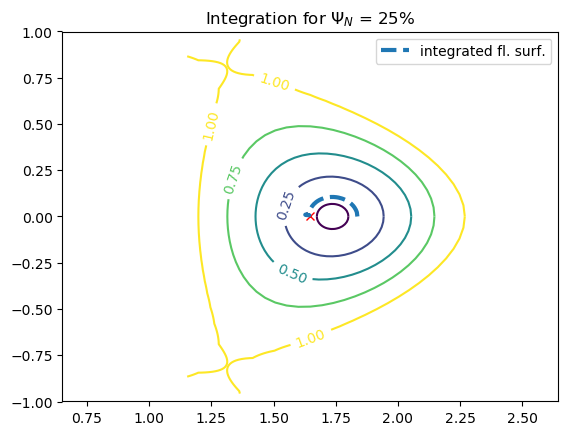

In [75]:
t = 26
sol = fs_integration(r_of_psi[t,8],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 25%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.03,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(X[1,1,1],Z[1,1,1],"rx")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

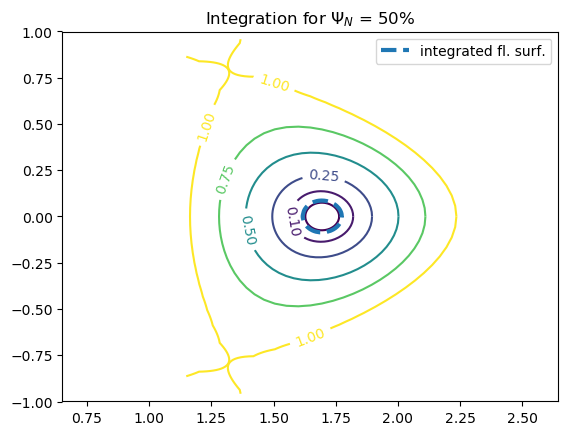

In [55]:
t = 2
sol = fs_integration(r_of_psi[t,5],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 50%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,1,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.03,0.1,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

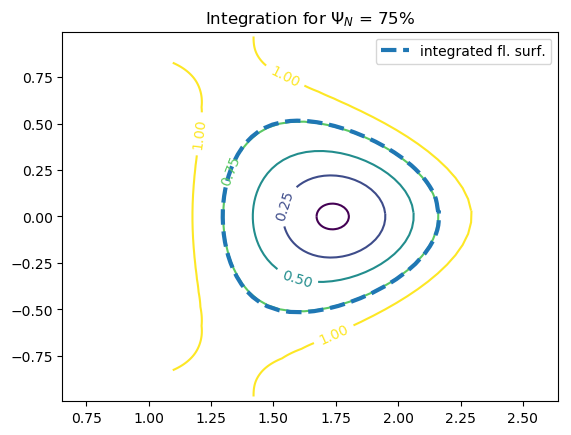

In [31]:
t = 26
sol = fs_integration(r_of_psi[t,76],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 75%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.03,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

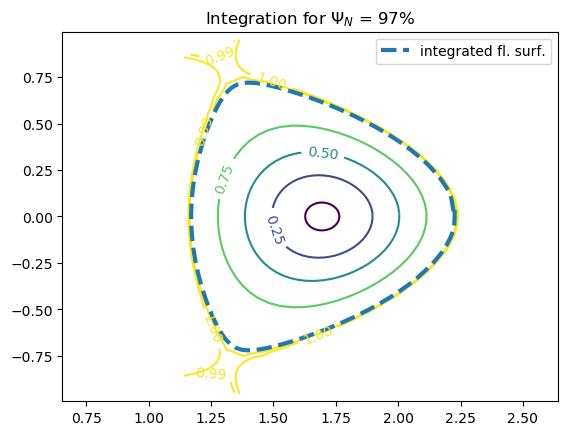

In [33]:
t = 2
sol = fs_integration(r_of_psi[t,98],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 97%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.03,0.25,0.5,0.75,0.99,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

The problem arises from this small dot near the magnetic axis. This is a region of space where there is a larger magnetic flux and the integration there has problems as shown below. Observe that even at 3% the integration proceeds normally. When it hits the small circle of larger flux, it breaks.(2nd plot)

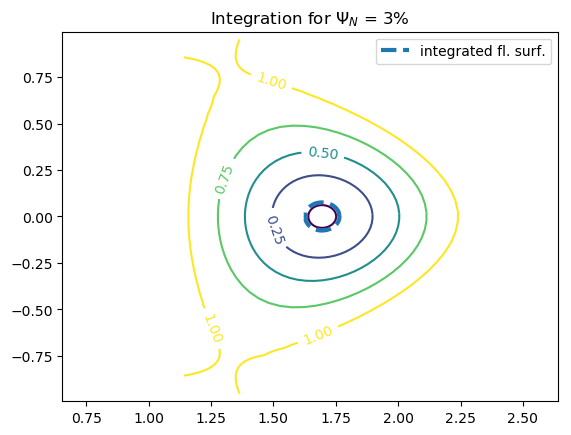

In [17]:
t = 2
sol = fs_integration(r_of_psi[t,4],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 3%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.02,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

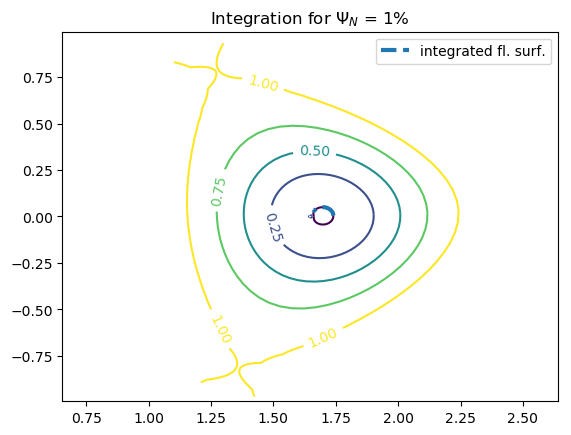

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /users/giannis_kx/.julia/packages/DiffEqBase/b38LC/src/integrator_interface.jl:329


In [186]:
t = 2
sol = fs_integration(r_of_psi[t,2],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 1%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

For the particular time step, t=2, this happens for a normalized flux of 1%. At other time steps though, this "bubble" of larger flux is further out. In the example below, the small bubble on the left of the 2% flux surface, corresponds to a flux of 25%.

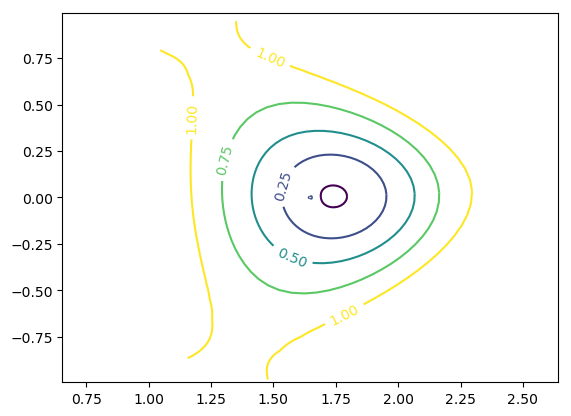

In [192]:
t = 26
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.02,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.show()

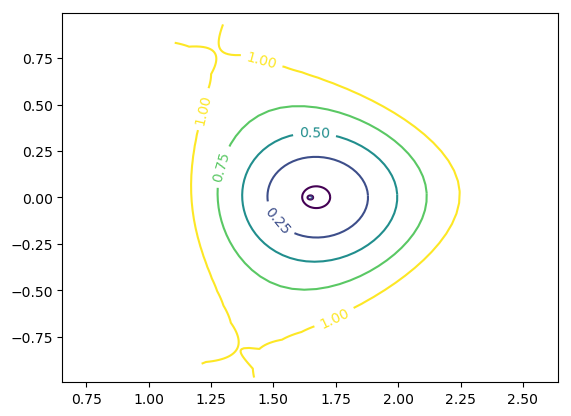

In [193]:
t = 1
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.02,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.show()

## Integration with magnetic field defined system

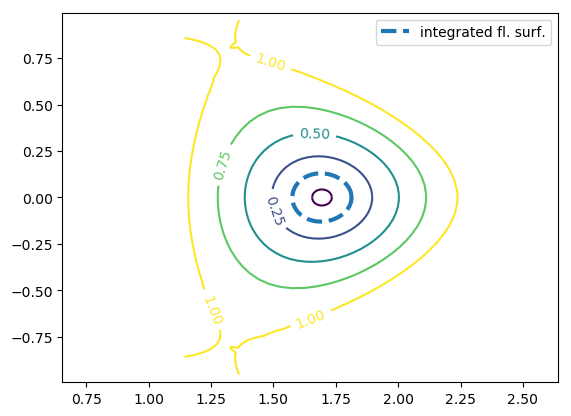

In [97]:
t = 11
sol = fs_integration_B(r_of_psi[t,10],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
#PyPlot.title(L"Integration for $\Psi_N$ = 1%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

## Integration with fixed flux

(t, u) = ([0.10038105507861671, 0.04752880355608765, -0.07833919918330638], 0.004781820504492619)
(t, u) = ([0.10033747231902373, 0.08695063661426043, -0.14328370705370186], 0.008738171423005968)
(t, u) = ([0.10033725027011008, 0.10083779700065973, -0.166133137084724], 0.010131576303339298)
(t, u) = ([0.10033046898495633, 0.1123039680733724, -0.18498532748886443], 0.011282054802246262)
(t, u) = ([0.100210433378854, 0.14685029292074125, -0.24171982229329309], 0.014749056371443144)
(t, u) = ([0.0998419196579759, 0.18380951501530554, -0.30236925386507635], 0.018465866571120062)
(t, u) = ([0.09961686068792522, 0.19908110764155937, -0.32743861926436263], 0.0200055159611779)
(t, u) = ([0.09943109814090917, 0.21026166423352843, -0.3458011519678515], 0.02113367178377881)
(t, u) = ([0.09873511906958946, 0.24723065291955065, -0.40658957782508065], 0.024862624362574116)
(t, u) = ([0.09784390398677803, 0.2901021726230896, -0.477237558934872], 0.029169930417700555)
(t, u) = ([0.09718423224684043, 0

(t, u) = ([0.007872721303461363, 2.006683676174791, -2.9209036340282184], 0.16659328770643111)
(t, u) = ([0.007872721298930184, 2.006683676174791, -2.9209036341253327], 0.1665932877115324)
(t, u) = ([0.007872721302810862, 2.006683676174791, -2.92090363404216], 0.16659328771541307)
(t, u) = ([0.007872721305880214, 2.006683676174791, -2.9209036339763763], 0.16659328772364068)
(t, u) = ([0.007872721305179402, 2.006683676174791, -2.9209036339913963], 0.16659328772934553)
(t, u) = ([0.007872721303550477, 2.006683676174791, -2.9209036340263084], 0.16659328773520815)
(t, u) = ([0.00787272129857262, 2.006683676174791, -2.9209036341329964], 0.1665932877408123)
(t, u) = ([0.007872721302844821, 2.006683676174791, -2.9209036340414327], 0.1665932877450845)
(t, u) = ([0.007872721305660989, 2.006683676174791, -2.920903633981075], 0.16659328775263343)
(t, u) = ([0.007872721305013666, 2.006683676174791, -2.920903633994949], 0.16659328775790286)
(t, u) = ([0.007872721303505529, 2.006683676174791, -2.920

(t, u) = ([0.00787272130349753, 2.006683676174791, -2.920903634027443], 0.16659328833115955)
(t, u) = ([0.007872721298331515, 2.006683676174791, -2.9209036341381633], 0.16659328833697554)
(t, u) = ([0.007872721302737421, 2.006683676174791, -2.920903634043734], 0.16659328834138146)
(t, u) = ([0.007872721306017514, 2.006683676174791, -2.9209036339734333], 0.16659328835017398)
(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.16659328835623913)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.1665932883624607)
(t, u) = ([0.00787272129882531, 2.006683676174791, -2.9209036341275803], 0.16659328836777282)
(t, u) = ([0.007872721302902558, 2.006683676174791, -2.9209036340401946], 0.16659328837185006)
(t, u) = ([0.007872721305335123, 2.006683676174791, -2.9209036339880585], 0.1665932883783707)
(t, u) = ([0.00787272130476957, 2.006683676174791, -2.92090363400018], 0.1665932883829745)
(t, u) = ([0.00787272130344667, 2.006683676174791, -2.92090363

(t, u) = ([0.00787272130345503, 2.006683676174791, -2.920903634028354], 0.16659328895558279)
(t, u) = ([0.007872721298907245, 2.006683676174791, -2.9209036341258243], 0.16659328896070275)
(t, u) = ([0.007872721302801691, 2.006683676174791, -2.920903634042357], 0.16659328896459719)
(t, u) = ([0.007872721305876736, 2.006683676174791, -2.920903633976451], 0.16659328897284006)
(t, u) = ([0.007872721305174725, 2.006683676174791, -2.9209036339914967], 0.1665932889785547)
(t, u) = ([0.007872721303543096, 2.006683676174791, -2.9209036340264665], 0.16659328898442702)
(t, u) = ([0.007872721298557865, 2.006683676174791, -2.920903634133312], 0.16659328899003947)
(t, u) = ([0.007872721302836219, 2.006683676174791, -2.9209036340416166], 0.16659328899431783)
(t, u) = ([0.007872721305654341, 2.006683676174791, -2.9209036339812173], 0.16659328900187198)
(t, u) = ([0.007872721305006604, 2.006683676174791, -2.9209036339951], 0.1665932890071448)
(t, u) = ([0.007872721303497528, 2.006683676174791, -2.92090

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /users/giannis_kx/.julia/packages/DiffEqBase/b38LC/src/integrator_interface.jl:329


(t, u) = ([0.007872721301247354, 2.006683676174791, -2.9209036340756693], 0.16659328956971903)
(t, u) = ([0.007872721301895091, 2.006683676174791, -2.9209036340617867], 0.16659328957499184)
(t, u) = ([0.007872721303404167, 2.006683676174791, -2.9209036340294436], 0.1665932895804231)
(t, u) = ([0.007872721308570182, 2.006683676174791, -2.9209036339187233], 0.1665932895862391)
(t, u) = ([0.007872721304164276, 2.006683676174791, -2.9209036340131527], 0.166593289590645)
(t, u) = ([0.007872721300884183, 2.006683676174791, -2.9209036340834533], 0.16659328959943753)
(t, u) = ([0.007872721301629257, 2.006683676174791, -2.9209036340674843], 0.16659328960550268)
(t, u) = ([0.007872721303357921, 2.006683676174791, -2.920903634030435], 0.16659328961172426)
(t, u) = ([0.007872721308076388, 2.006683676174791, -2.9209036339293064], 0.16659328961703637)
(t, u) = ([0.00787272130399914, 2.006683676174791, -2.920903634016692], 0.1665932896211136)
(t, u) = ([0.007872721301566575, 2.006683676174791, -2.920

(t, u) = ([0.007872721302902558, 2.006683676174791, -2.9209036340401946], 0.16659329018896069)
(t, u) = ([0.007872721305335123, 2.006683676174791, -2.9209036339880585], 0.16659329019548133)
(t, u) = ([0.00787272130476957, 2.006683676174791, -2.92090363400018], 0.16659329020008512)
(t, u) = ([0.007872721303446668, 2.006683676174791, -2.920903634028533], 0.16659329020484634)
(t, u) = ([0.007872721307994452, 2.006683676174791, -2.9209036339310623], 0.1665932902099663)
(t, u) = ([0.007872721304100007, 2.006683676174791, -2.92090363401453], 0.16659329021386074)
(t, u) = ([0.007872721301024961, 2.006683676174791, -2.9209036340804357], 0.16659329022210362)
(t, u) = ([0.007872721301726972, 2.006683676174791, -2.92090363406539], 0.16659329022781824)
(t, u) = ([0.007872721303358601, 2.006683676174791, -2.92090363403042], 0.16659329023369057)
(t, u) = ([0.007872721308343832, 2.006683676174791, -2.9209036339235745], 0.16659329023930303)
(t, u) = ([0.007872721304065479, 2.006683676174791, -2.920903

(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.16659329080715007)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036340416166], 0.16659329081142843)
(t, u) = ([0.007872721305654343, 2.006683676174791, -2.9209036339812173], 0.16659329081898258)
(t, u) = ([0.007872721305006606, 2.006683676174791, -2.9209036339951], 0.1665932908242554)
(t, u) = ([0.00787272130349753, 2.006683676174791, -2.920903634027443], 0.16659329082968666)
(t, u) = ([0.007872721298331515, 2.006683676174791, -2.9209036341381633], 0.16659329083550264)
(t, u) = ([0.007872721302737421, 2.006683676174791, -2.920903634043734], 0.16659329083990856)
(t, u) = ([0.007872721306017514, 2.006683676174791, -2.9209036339734333], 0.1665932908487011)
(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.16659329085476623)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.1665932908609878)
(t, u) = ([0.00787272129882531, 2.006683676174791, -2.920903634

(t, u) = ([0.007872721301629262, 2.006683676174791, -2.9209036340674843], 0.16659329142261328)
(t, u) = ([0.007872721303357927, 2.006683676174791, -2.920903634030435], 0.16659329142883486)
(t, u) = ([0.007872721308076392, 2.006683676174791, -2.9209036339293064], 0.16659329143414697)
(t, u) = ([0.007872721303999143, 2.006683676174791, -2.920903634016692], 0.1665932914382242)
(t, u) = ([0.007872721301566578, 2.006683676174791, -2.920903634068828], 0.16659329144474486)
(t, u) = ([0.007872721302132131, 2.006683676174791, -2.9209036340567067], 0.16659329144934865)
(t, u) = ([0.007872721303455031, 2.006683676174791, -2.920903634028354], 0.16659329145410987)
(t, u) = ([0.007872721298907247, 2.006683676174791, -2.9209036341258243], 0.16659329145922983)
(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.16659329146312427)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.16659329147136714)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.92

(t, u) = ([0.007872721304100005, 2.006683676174791, -2.92090363401453], 0.16659329203097134)
(t, u) = ([0.00787272130102496, 2.006683676174791, -2.9209036340804357], 0.16659329203921422)
(t, u) = ([0.00787272130172697, 2.006683676174791, -2.92090363406539], 0.16659329204492884)
(t, u) = ([0.0078727213033586, 2.006683676174791, -2.92090363403042], 0.16659329205080117)
(t, u) = ([0.00787272130834383, 2.006683676174791, -2.9209036339235745], 0.16659329205641363)
(t, u) = ([0.007872721304065477, 2.006683676174791, -2.92090363401527], 0.16659329206069198)
(t, u) = ([0.007872721301247354, 2.006683676174791, -2.9209036340756693], 0.16659329206824613)
(t, u) = ([0.007872721301895091, 2.006683676174791, -2.9209036340617867], 0.16659329207351894)
(t, u) = ([0.007872721303404167, 2.006683676174791, -2.9209036340294436], 0.1665932920789502)
(t, u) = ([0.007872721308570182, 2.006683676174791, -2.9209036339187233], 0.1665932920847662)
(t, u) = ([0.007872721304164276, 2.006683676174791, -2.9209036340

(t, u) = ([0.007872721302737416, 2.006683676174791, -2.920903634043734], 0.1665932926570192)
(t, u) = ([0.00787272130601751, 2.006683676174791, -2.9209036339734333], 0.1665932926658117)
(t, u) = ([0.007872721305272435, 2.006683676174791, -2.9209036339894023], 0.16659329267187684)
(t, u) = ([0.007872721303543771, 2.006683676174791, -2.920903634026452], 0.16659329267809841)
(t, u) = ([0.007872721298825306, 2.006683676174791, -2.9209036341275803], 0.16659329268341053)
(t, u) = ([0.007872721302902555, 2.006683676174791, -2.9209036340401946], 0.16659329268748777)
(t, u) = ([0.00787272130533512, 2.006683676174791, -2.9209036339880585], 0.1665932926940084)
(t, u) = ([0.007872721304769566, 2.006683676174791, -2.92090363400018], 0.1665932926986122)
(t, u) = ([0.007872721303446666, 2.006683676174791, -2.920903634028533], 0.16659329270337342)
(t, u) = ([0.00787272130799445, 2.006683676174791, -2.9209036339310623], 0.16659329270849338)
(t, u) = ([0.007872721304100005, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721302801687, 2.006683676174791, -2.920903634042357], 0.1665932932802349)
(t, u) = ([0.007872721305876733, 2.006683676174791, -2.920903633976451], 0.16659329328847777)
(t, u) = ([0.007872721305174721, 2.006683676174791, -2.9209036339914967], 0.1665932932941924)
(t, u) = ([0.007872721303543093, 2.006683676174791, -2.9209036340264665], 0.16659329330006473)
(t, u) = ([0.007872721298557862, 2.006683676174791, -2.920903634133312], 0.16659329330567718)
(t, u) = ([0.007872721302836215, 2.006683676174791, -2.9209036340416166], 0.16659329330995554)
(t, u) = ([0.007872721305654338, 2.006683676174791, -2.9209036339812173], 0.1665932933175097)
(t, u) = ([0.0078727213050066, 2.006683676174791, -2.9209036339951], 0.1665932933227825)
(t, u) = ([0.007872721303497525, 2.006683676174791, -2.920903634027443], 0.16659329332821377)
(t, u) = ([0.00787272129833151, 2.006683676174791, -2.9209036341381633], 0.16659329333402975)
(t, u) = ([0.007872721302737416, 2.006683676174791, -2.920903634

(t, u) = ([0.007872721304164281, 2.006683676174791, -2.9209036340131527], 0.16659329390628275)
(t, u) = ([0.007872721300884188, 2.006683676174791, -2.9209036340834533], 0.16659329391507524)
(t, u) = ([0.007872721301629262, 2.006683676174791, -2.9209036340674843], 0.1665932939211404)
(t, u) = ([0.007872721303357927, 2.006683676174791, -2.920903634030435], 0.16659329392736197)
(t, u) = ([0.007872721308076392, 2.006683676174791, -2.9209036339293064], 0.16659329393267408)
(t, u) = ([0.007872721303999143, 2.006683676174791, -2.920903634016692], 0.16659329393675132)
(t, u) = ([0.007872721301566578, 2.006683676174791, -2.920903634068828], 0.16659329394327196)
(t, u) = ([0.007872721302132131, 2.006683676174791, -2.9209036340567067], 0.16659329394787575)
(t, u) = ([0.007872721303455031, 2.006683676174791, -2.920903634028354], 0.16659329395263697)
(t, u) = ([0.007872721298907247, 2.006683676174791, -2.9209036341258243], 0.16659329395775693)
(t, u) = ([0.007872721302801693, 2.006683676174791, -2.

(t, u) = ([0.007872721306017514, 2.006683676174791, -2.9209036339734333], 0.16659329448292232)
(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.16659329448898746)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.16659329449520904)
(t, u) = ([0.007872721298825311, 2.006683676174791, -2.9209036341275803], 0.16659329450052116)
(t, u) = ([0.00787272130290256, 2.006683676174791, -2.9209036340401946], 0.1665932945045984)
(t, u) = ([0.007872721305335124, 2.006683676174791, -2.9209036339880585], 0.16659329451111904)
(t, u) = ([0.007872721304769572, 2.006683676174791, -2.92090363400018], 0.16659329451572283)
(t, u) = ([0.007872721303446671, 2.006683676174791, -2.920903634028533], 0.16659329452048405)
(t, u) = ([0.007872721307994456, 2.006683676174791, -2.9209036339310623], 0.166593294525604)
(t, u) = ([0.00787272130410001, 2.006683676174791, -2.92090363401453], 0.16659329452949845)
(t, u) = ([0.007872721301024965, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.16659329509734552)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.1665932951055884)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.9209036339914967], 0.16659329511130302)
(t, u) = ([0.007872721303543098, 2.006683676174791, -2.9209036340264665], 0.16659329511717536)
(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.1665932951227878)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036340416166], 0.16659329512706617)
(t, u) = ([0.007872721305654343, 2.006683676174791, -2.9209036339812173], 0.16659329513462032)
(t, u) = ([0.007872721305006606, 2.006683676174791, -2.9209036339951], 0.16659329513989313)
(t, u) = ([0.00787272130349753, 2.006683676174791, -2.920903634027443], 0.1665932951453244)
(t, u) = ([0.007872721298331515, 2.006683676174791, -2.9209036341381633], 0.16659329515114038)
(t, u) = ([0.007872721302737421, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721304164276, 2.006683676174791, -2.9209036340131527], 0.16659329572339338)
(t, u) = ([0.007872721300884183, 2.006683676174791, -2.9209036340834533], 0.16659329573218587)
(t, u) = ([0.007872721301629257, 2.006683676174791, -2.9209036340674843], 0.16659329573825102)
(t, u) = ([0.007872721303357921, 2.006683676174791, -2.920903634030435], 0.1665932957444726)
(t, u) = ([0.007872721308076387, 2.006683676174791, -2.9209036339293064], 0.1665932957497847)
(t, u) = ([0.007872721303999138, 2.006683676174791, -2.920903634016692], 0.16659329575386195)
(t, u) = ([0.007872721301566573, 2.006683676174791, -2.920903634068828], 0.1665932957603826)
(t, u) = ([0.007872721302132126, 2.006683676174791, -2.9209036340567067], 0.16659329576498638)
(t, u) = ([0.007872721303455026, 2.006683676174791, -2.920903634028354], 0.1665932957697476)
(t, u) = ([0.007872721298907242, 2.006683676174791, -2.9209036341258243], 0.16659329577486756)
(t, u) = ([0.007872721302801687, 2.006683676174791, -2.920

(t, u) = ([0.007872721304100005, 2.006683676174791, -2.92090363401453], 0.16659329634660908)
(t, u) = ([0.00787272130102496, 2.006683676174791, -2.9209036340804357], 0.16659329635485196)
(t, u) = ([0.00787272130172697, 2.006683676174791, -2.92090363406539], 0.16659329636056658)
(t, u) = ([0.0078727213033586, 2.006683676174791, -2.92090363403042], 0.1665932963664389)
(t, u) = ([0.00787272130834383, 2.006683676174791, -2.9209036339235745], 0.16659329637205136)
(t, u) = ([0.007872721304065477, 2.006683676174791, -2.92090363401527], 0.16659329637632972)
(t, u) = ([0.007872721301247354, 2.006683676174791, -2.9209036340756693], 0.16659329638388387)
(t, u) = ([0.007872721301895091, 2.006683676174791, -2.9209036340617867], 0.16659329638915668)
(t, u) = ([0.007872721303404167, 2.006683676174791, -2.9209036340294436], 0.16659329639458795)
(t, u) = ([0.007872721308570182, 2.006683676174791, -2.9209036339187233], 0.16659329640040393)
(t, u) = ([0.007872721304164276, 2.006683676174791, -2.920903634

(t, u) = ([0.007872721305654341, 2.006683676174791, -2.9209036339812173], 0.16659329695173092)
(t, u) = ([0.007872721305006604, 2.006683676174791, -2.9209036339951], 0.16659329695700373)
(t, u) = ([0.007872721303497528, 2.006683676174791, -2.920903634027443], 0.166593296962435)
(t, u) = ([0.007872721298331513, 2.006683676174791, -2.9209036341381633], 0.16659329696825098)
(t, u) = ([0.00787272130273742, 2.006683676174791, -2.920903634043734], 0.1665932969726569)
(t, u) = ([0.007872721306017513, 2.006683676174791, -2.9209036339734333], 0.16659329698144942)
(t, u) = ([0.007872721305272438, 2.006683676174791, -2.9209036339894023], 0.16659329698751457)
(t, u) = ([0.007872721303543774, 2.006683676174791, -2.920903634026452], 0.16659329699373615)
(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209036341275803], 0.16659329699904826)
(t, u) = ([0.007872721302902556, 2.006683676174791, -2.9209036340401946], 0.1665932970031255)
(t, u) = ([0.007872721305335121, 2.006683676174791, -2.920903

(t, u) = ([0.007872721303999141, 2.006683676174791, -2.920903634016692], 0.16659329757097258)
(t, u) = ([0.007872721301566576, 2.006683676174791, -2.920903634068828], 0.16659329757749322)
(t, u) = ([0.00787272130213213, 2.006683676174791, -2.9209036340567067], 0.166593297582097)
(t, u) = ([0.007872721303455031, 2.006683676174791, -2.920903634028354], 0.16659329758685823)
(t, u) = ([0.007872721298907247, 2.006683676174791, -2.9209036341258243], 0.1665932975919782)
(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.16659329759587263)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.1665932976041155)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.9209036339914967], 0.16659329760983013)
(t, u) = ([0.007872721303543098, 2.006683676174791, -2.9209036340264665], 0.16659329761570246)
(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.16659329762131492)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721308343832, 2.006683676174791, -2.9209036339235745], 0.16659329818916196)
(t, u) = ([0.007872721304065479, 2.006683676174791, -2.92090363401527], 0.16659329819344032)
(t, u) = ([0.007872721301247356, 2.006683676174791, -2.9209036340756693], 0.16659329820099447)
(t, u) = ([0.007872721301895093, 2.006683676174791, -2.9209036340617867], 0.16659329820626728)
(t, u) = ([0.007872721303404169, 2.006683676174791, -2.9209036340294436], 0.16659329821169855)
(t, u) = ([0.007872721308570184, 2.006683676174791, -2.9209036339187233], 0.16659329821751453)
(t, u) = ([0.007872721304164278, 2.006683676174791, -2.9209036340131527], 0.16659329822192046)
(t, u) = ([0.007872721300884185, 2.006683676174791, -2.9209036340834533], 0.16659329823071298)
(t, u) = ([0.007872721301629259, 2.006683676174791, -2.9209036340674843], 0.16659329823677813)
(t, u) = ([0.007872721303357923, 2.006683676174791, -2.920903634030435], 0.1665932982429997)
(t, u) = ([0.00787272130807639, 2.006683676174791, -2.

(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209036341275803], 0.16659329881615886)
(t, u) = ([0.007872721302902556, 2.006683676174791, -2.9209036340401946], 0.1665932988202361)
(t, u) = ([0.007872721305335121, 2.006683676174791, -2.9209036339880585], 0.16659329882675675)
(t, u) = ([0.007872721304769568, 2.006683676174791, -2.92090363400018], 0.16659329883136054)
(t, u) = ([0.007872721303446668, 2.006683676174791, -2.920903634028533], 0.16659329883612176)
(t, u) = ([0.007872721307994452, 2.006683676174791, -2.9209036339310623], 0.16659329884124172)
(t, u) = ([0.007872721304100007, 2.006683676174791, -2.92090363401453], 0.16659329884513616)
(t, u) = ([0.007872721301024961, 2.006683676174791, -2.9209036340804357], 0.16659329885337903)
(t, u) = ([0.007872721301726972, 2.006683676174791, -2.92090363406539], 0.16659329885909366)
(t, u) = ([0.007872721303358601, 2.006683676174791, -2.92090363403042], 0.166593298864966)
(t, u) = ([0.007872721308343832, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721301566576, 2.006683676174791, -2.920903634068828], 0.16659329939460382)
(t, u) = ([0.00787272130213213, 2.006683676174791, -2.9209036340567067], 0.1665932993992076)
(t, u) = ([0.00787272130345503, 2.006683676174791, -2.920903634028354], 0.16659329940396883)
(t, u) = ([0.007872721298907245, 2.006683676174791, -2.9209036341258243], 0.1665932994090888)
(t, u) = ([0.007872721302801691, 2.006683676174791, -2.920903634042357], 0.16659329941298323)
(t, u) = ([0.007872721305876736, 2.006683676174791, -2.920903633976451], 0.1665932994212261)
(t, u) = ([0.007872721305174725, 2.006683676174791, -2.9209036339914967], 0.16659329942694073)
(t, u) = ([0.007872721303543096, 2.006683676174791, -2.9209036340264665], 0.16659329943281306)
(t, u) = ([0.007872721298557865, 2.006683676174791, -2.920903634133312], 0.16659329943842552)
(t, u) = ([0.007872721302836219, 2.006683676174791, -2.9209036340416166], 0.16659329944270387)
(t, u) = ([0.007872721305654341, 2.006683676174791, -2.92090

(t, u) = ([0.007872721301247358, 2.006683676174791, -2.9209036340756693], 0.1665933000181051)
(t, u) = ([0.007872721301895095, 2.006683676174791, -2.9209036340617867], 0.1665933000233779)
(t, u) = ([0.00787272130340417, 2.006683676174791, -2.9209036340294436], 0.16659330002880918)
(t, u) = ([0.007872721308570186, 2.006683676174791, -2.9209036339187233], 0.16659330003462516)
(t, u) = ([0.00787272130416428, 2.006683676174791, -2.9209036340131527], 0.16659330003903108)
(t, u) = ([0.007872721300884187, 2.006683676174791, -2.9209036340834533], 0.16659330004782358)
(t, u) = ([0.00787272130162926, 2.006683676174791, -2.9209036340674843], 0.16659330005388873)
(t, u) = ([0.007872721303357925, 2.006683676174791, -2.920903634030435], 0.1665933000601103)
(t, u) = ([0.00787272130807639, 2.006683676174791, -2.9209036339293064], 0.16659330006542242)
(t, u) = ([0.007872721303999141, 2.006683676174791, -2.920903634016692], 0.16659330006949966)
(t, u) = ([0.007872721301566576, 2.006683676174791, -2.9209

(t, u) = ([0.007872721302902558, 2.006683676174791, -2.9209036340401946], 0.16659330063734673)
(t, u) = ([0.007872721305335123, 2.006683676174791, -2.9209036339880585], 0.16659330064386738)
(t, u) = ([0.00787272130476957, 2.006683676174791, -2.92090363400018], 0.16659330064847117)
(t, u) = ([0.00787272130344667, 2.006683676174791, -2.920903634028533], 0.16659330065323238)
(t, u) = ([0.007872721307994454, 2.006683676174791, -2.9209036339310623], 0.16659330065835234)
(t, u) = ([0.007872721304100008, 2.006683676174791, -2.92090363401453], 0.16659330066224678)
(t, u) = ([0.007872721301024963, 2.006683676174791, -2.9209036340804357], 0.16659330067048966)
(t, u) = ([0.007872721301726974, 2.006683676174791, -2.92090363406539], 0.1665933006762043)
(t, u) = ([0.007872721303358603, 2.006683676174791, -2.92090363403042], 0.16659330068207662)
(t, u) = ([0.007872721308343834, 2.006683676174791, -2.9209036339235745], 0.16659330068768907)
(t, u) = ([0.00787272130406548, 2.006683676174791, -2.92090363

(t, u) = ([0.007872721298557863, 2.006683676174791, -2.920903634133312], 0.16659330125553615)
(t, u) = ([0.007872721302836217, 2.006683676174791, -2.9209036340416166], 0.1665933012598145)
(t, u) = ([0.00787272130565434, 2.006683676174791, -2.9209036339812173], 0.16659330126736865)
(t, u) = ([0.007872721305006602, 2.006683676174791, -2.9209036339951], 0.16659330127264146)
(t, u) = ([0.007872721303497527, 2.006683676174791, -2.920903634027443], 0.16659330127807273)
(t, u) = ([0.007872721298331511, 2.006683676174791, -2.9209036341381633], 0.16659330128388872)
(t, u) = ([0.007872721302737418, 2.006683676174791, -2.920903634043734], 0.16659330128829464)
(t, u) = ([0.007872721306017511, 2.006683676174791, -2.9209036339734333], 0.16659330129708713)
(t, u) = ([0.007872721305272437, 2.006683676174791, -2.9209036339894023], 0.16659330130315228)
(t, u) = ([0.007872721303543773, 2.006683676174791, -2.920903634026452], 0.16659330130937386)
(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209

(t, u) = ([0.007872721308076388, 2.006683676174791, -2.9209036339293064], 0.16659330188253305)
(t, u) = ([0.00787272130399914, 2.006683676174791, -2.920903634016692], 0.16659330188661028)
(t, u) = ([0.007872721301566575, 2.006683676174791, -2.920903634068828], 0.16659330189313093)
(t, u) = ([0.007872721302132128, 2.006683676174791, -2.9209036340567067], 0.16659330189773472)
(t, u) = ([0.007872721303455028, 2.006683676174791, -2.920903634028354], 0.16659330190249594)
(t, u) = ([0.007872721298907244, 2.006683676174791, -2.9209036341258243], 0.1665933019076159)
(t, u) = ([0.00787272130280169, 2.006683676174791, -2.920903634042357], 0.16659330191151034)
(t, u) = ([0.007872721305876735, 2.006683676174791, -2.920903633976451], 0.16659330191975322)
(t, u) = ([0.007872721305174723, 2.006683676174791, -2.9209036339914967], 0.16659330192546784)
(t, u) = ([0.007872721303543094, 2.006683676174791, -2.9209036340264665], 0.16659330193134017)
(t, u) = ([0.007872721298557863, 2.006683676174791, -2.920

(t, u) = ([0.007872721308343832, 2.006683676174791, -2.9209036339235745], 0.1665933025047997)
(t, u) = ([0.007872721304065479, 2.006683676174791, -2.92090363401527], 0.16659330250907806)
(t, u) = ([0.007872721301247356, 2.006683676174791, -2.9209036340756693], 0.1665933025166322)
(t, u) = ([0.007872721301895093, 2.006683676174791, -2.9209036340617867], 0.16659330252190502)
(t, u) = ([0.007872721303404169, 2.006683676174791, -2.9209036340294436], 0.16659330252733628)
(t, u) = ([0.007872721308570184, 2.006683676174791, -2.9209036339187233], 0.16659330253315227)
(t, u) = ([0.007872721304164278, 2.006683676174791, -2.9209036340131527], 0.1665933025375582)
(t, u) = ([0.007872721300884185, 2.006683676174791, -2.9209036340834533], 0.16659330254635069)
(t, u) = ([0.007872721301629259, 2.006683676174791, -2.9209036340674843], 0.16659330255241583)
(t, u) = ([0.007872721303357923, 2.006683676174791, -2.920903634030435], 0.1665933025586374)
(t, u) = ([0.007872721308076388, 2.006683676174791, -2.92

(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.1665933031202629)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.1665933031264845)
(t, u) = ([0.00787272129882531, 2.006683676174791, -2.9209036341275803], 0.1665933031317966)
(t, u) = ([0.007872721302902558, 2.006683676174791, -2.9209036340401946], 0.16659330313587384)
(t, u) = ([0.007872721305335123, 2.006683676174791, -2.9209036339880585], 0.16659330314239448)
(t, u) = ([0.00787272130476957, 2.006683676174791, -2.92090363400018], 0.16659330314699827)
(t, u) = ([0.00787272130344667, 2.006683676174791, -2.920903634028533], 0.1665933031517595)
(t, u) = ([0.007872721307994454, 2.006683676174791, -2.9209036339310623], 0.16659330315687945)
(t, u) = ([0.007872721304100008, 2.006683676174791, -2.92090363401453], 0.1665933031607739)
(t, u) = ([0.007872721301024963, 2.006683676174791, -2.9209036340804357], 0.16659330316901677)
(t, u) = ([0.007872721301726974, 2.006683676174791, -2.9209036340

(t, u) = ([0.007872721305174725, 2.006683676174791, -2.9209036339914967], 0.16659330374257847)
(t, u) = ([0.007872721303543096, 2.006683676174791, -2.9209036340264665], 0.1665933037484508)
(t, u) = ([0.007872721298557865, 2.006683676174791, -2.920903634133312], 0.16659330375406325)
(t, u) = ([0.007872721302836219, 2.006683676174791, -2.9209036340416166], 0.1665933037583416)
(t, u) = ([0.007872721305654341, 2.006683676174791, -2.9209036339812173], 0.16659330376589576)
(t, u) = ([0.007872721305006604, 2.006683676174791, -2.9209036339951], 0.16659330377116857)
(t, u) = ([0.007872721303497528, 2.006683676174791, -2.920903634027443], 0.16659330377659984)
(t, u) = ([0.007872721298331513, 2.006683676174791, -2.9209036341381633], 0.16659330378241582)
(t, u) = ([0.00787272130273742, 2.006683676174791, -2.920903634043734], 0.16659330378682174)
(t, u) = ([0.007872721306017513, 2.006683676174791, -2.9209036339734333], 0.16659330379561424)
(t, u) = ([0.007872721305272438, 2.006683676174791, -2.9209

(t, u) = ([0.007872721308570182, 2.006683676174791, -2.9209036339187233], 0.16659330435026287)
(t, u) = ([0.007872721304164276, 2.006683676174791, -2.9209036340131527], 0.1665933043546688)
(t, u) = ([0.007872721300884183, 2.006683676174791, -2.9209036340834533], 0.16659330436346131)
(t, u) = ([0.007872721301629257, 2.006683676174791, -2.9209036340674843], 0.16659330436952646)
(t, u) = ([0.007872721303357921, 2.006683676174791, -2.920903634030435], 0.16659330437574804)
(t, u) = ([0.007872721308076388, 2.006683676174791, -2.9209036339293064], 0.16659330438106015)
(t, u) = ([0.00787272130399914, 2.006683676174791, -2.920903634016692], 0.1665933043851374)
(t, u) = ([0.007872721301566575, 2.006683676174791, -2.920903634068828], 0.16659330439165804)
(t, u) = ([0.007872721302132128, 2.006683676174791, -2.9209036340567067], 0.16659330439626183)
(t, u) = ([0.00787272130345503, 2.006683676174791, -2.920903634028354], 0.16659330440102305)
(t, u) = ([0.007872721298907245, 2.006683676174791, -2.920

(t, u) = ([0.007872721303446666, 2.006683676174791, -2.920903634028533], 0.1665933049688701)
(t, u) = ([0.00787272130799445, 2.006683676174791, -2.9209036339310623], 0.16659330497399005)
(t, u) = ([0.007872721304100005, 2.006683676174791, -2.92090363401453], 0.1665933049778845)
(t, u) = ([0.00787272130102496, 2.006683676174791, -2.9209036340804357], 0.16659330498612737)
(t, u) = ([0.00787272130172697, 2.006683676174791, -2.92090363406539], 0.166593304991842)
(t, u) = ([0.0078727213033586, 2.006683676174791, -2.92090363403042], 0.16659330499771433)
(t, u) = ([0.00787272130834383, 2.006683676174791, -2.9209036339235745], 0.16659330500332678)
(t, u) = ([0.007872721304065477, 2.006683676174791, -2.92090363401527], 0.16659330500760514)
(t, u) = ([0.007872721301247354, 2.006683676174791, -2.9209036340756693], 0.1665933050151593)
(t, u) = ([0.007872721301895091, 2.006683676174791, -2.9209036340617867], 0.1665933050204321)
(t, u) = ([0.007872721303404167, 2.006683676174791, -2.9209036340294436

(t, u) = ([0.00787272130349753, 2.006683676174791, -2.920903634027443], 0.16659330559371044)
(t, u) = ([0.007872721298331515, 2.006683676174791, -2.9209036341381633], 0.16659330559952643)
(t, u) = ([0.007872721302737421, 2.006683676174791, -2.920903634043734], 0.16659330560393235)
(t, u) = ([0.007872721306017514, 2.006683676174791, -2.9209036339734333], 0.16659330561272487)
(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.16659330561879002)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.1665933056250116)
(t, u) = ([0.00787272129882531, 2.006683676174791, -2.9209036341275803], 0.1665933056303237)
(t, u) = ([0.007872721302902558, 2.006683676174791, -2.9209036340401946], 0.16659330563440095)
(t, u) = ([0.007872721305335123, 2.006683676174791, -2.9209036339880585], 0.1665933056409216)
(t, u) = ([0.00787272130476957, 2.006683676174791, -2.92090363400018], 0.16659330564552538)
(t, u) = ([0.007872721303446668, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721302132131, 2.006683676174791, -2.9209036340567067], 0.16659330621337243)
(t, u) = ([0.007872721303455031, 2.006683676174791, -2.920903634028354], 0.16659330621813365)
(t, u) = ([0.007872721298907247, 2.006683676174791, -2.9209036341258243], 0.1665933062232536)
(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.16659330622714805)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.16659330623539093)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.9209036339914967], 0.16659330624110555)
(t, u) = ([0.007872721303543098, 2.006683676174791, -2.9209036340264665], 0.16659330624697788)
(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.16659330625259033)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036340416166], 0.1665933062568687)
(t, u) = ([0.007872721305654343, 2.006683676174791, -2.9209036339812173], 0.16659330626442284)
(t, u) = ([0.007872721305006606, 2.006683676174791, -2.92

(t, u) = ([0.007872721304065482, 2.006683676174791, -2.92090363401527], 0.16659330682471576)
(t, u) = ([0.00787272130124736, 2.006683676174791, -2.9209036340756693], 0.16659330683226992)
(t, u) = ([0.007872721301895097, 2.006683676174791, -2.9209036340617867], 0.16659330683754273)
(t, u) = ([0.007872721303404173, 2.006683676174791, -2.9209036340294436], 0.166593306842974)
(t, u) = ([0.007872721308570188, 2.006683676174791, -2.9209036339187233], 0.16659330684878998)
(t, u) = ([0.007872721304164281, 2.006683676174791, -2.9209036340131527], 0.1665933068531959)
(t, u) = ([0.007872721300884188, 2.006683676174791, -2.9209036340834533], 0.1665933068619884)
(t, u) = ([0.007872721301629262, 2.006683676174791, -2.9209036340674843], 0.16659330686805354)
(t, u) = ([0.007872721303357927, 2.006683676174791, -2.920903634030435], 0.16659330687427512)
(t, u) = ([0.007872721308076392, 2.006683676174791, -2.9209036339293064], 0.16659330687958723)
(t, u) = ([0.007872721303999143, 2.006683676174791, -2.920

(t, u) = ([0.007872721298825306, 2.006683676174791, -2.9209036341275803], 0.1665933074474343)
(t, u) = ([0.007872721302902555, 2.006683676174791, -2.9209036340401946], 0.16659330745151155)
(t, u) = ([0.00787272130533512, 2.006683676174791, -2.9209036339880585], 0.1665933074580322)
(t, u) = ([0.007872721304769566, 2.006683676174791, -2.92090363400018], 0.16659330746263598)
(t, u) = ([0.007872721303446666, 2.006683676174791, -2.920903634028533], 0.1665933074673972)
(t, u) = ([0.00787272130799445, 2.006683676174791, -2.9209036339310623], 0.16659330747251716)
(t, u) = ([0.007872721304100005, 2.006683676174791, -2.92090363401453], 0.1665933074764116)
(t, u) = ([0.00787272130102496, 2.006683676174791, -2.9209036340804357], 0.16659330748465448)
(t, u) = ([0.00787272130172697, 2.006683676174791, -2.92090363406539], 0.1665933074903691)
(t, u) = ([0.0078727213033586, 2.006683676174791, -2.92090363403042], 0.16659330749624143)
(t, u) = ([0.00787272130834383, 2.006683676174791, -2.9209036339235745

(t, u) = ([0.007872721298557862, 2.006683676174791, -2.920903634133312], 0.16659330806970096)
(t, u) = ([0.007872721302836215, 2.006683676174791, -2.9209036340416166], 0.16659330807397932)
(t, u) = ([0.007872721305654338, 2.006683676174791, -2.9209036339812173], 0.16659330808153347)
(t, u) = ([0.0078727213050066, 2.006683676174791, -2.9209036339951], 0.16659330808680628)
(t, u) = ([0.007872721303497525, 2.006683676174791, -2.920903634027443], 0.16659330809223755)
(t, u) = ([0.00787272129833151, 2.006683676174791, -2.9209036341381633], 0.16659330809805353)
(t, u) = ([0.007872721302737416, 2.006683676174791, -2.920903634043734], 0.16659330810245945)
(t, u) = ([0.00787272130601751, 2.006683676174791, -2.9209036339734333], 0.16659330811125195)
(t, u) = ([0.007872721305272435, 2.006683676174791, -2.9209036339894023], 0.1665933081173171)
(t, u) = ([0.007872721303543771, 2.006683676174791, -2.920903634026452], 0.16659330812353867)
(t, u) = ([0.007872721298825306, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721308076387, 2.006683676174791, -2.9209036339293064], 0.16659330869669786)
(t, u) = ([0.007872721303999138, 2.006683676174791, -2.920903634016692], 0.1665933087007751)
(t, u) = ([0.007872721301566573, 2.006683676174791, -2.920903634068828], 0.16659330870729575)
(t, u) = ([0.007872721302132126, 2.006683676174791, -2.9209036340567067], 0.16659330871189953)
(t, u) = ([0.007872721303455026, 2.006683676174791, -2.920903634028354], 0.16659330871666075)
(t, u) = ([0.007872721298907242, 2.006683676174791, -2.9209036341258243], 0.16659330872178071)
(t, u) = ([0.007872721302801687, 2.006683676174791, -2.920903634042357], 0.16659330872567515)
(t, u) = ([0.007872721305876733, 2.006683676174791, -2.920903633976451], 0.16659330873391803)
(t, u) = ([0.007872721305174721, 2.006683676174791, -2.9209036339914967], 0.16659330873963266)
(t, u) = ([0.007872721303543093, 2.006683676174791, -2.9209036340264665], 0.166593308745505)
(t, u) = ([0.007872721298557862, 2.006683676174791, -2.920

(t, u) = ([0.007872721301024965, 2.006683676174791, -2.9209036340804357], 0.1665933093017651)
(t, u) = ([0.007872721301726976, 2.006683676174791, -2.92090363406539], 0.16659330930747973)
(t, u) = ([0.007872721303358605, 2.006683676174791, -2.92090363403042], 0.16659330931335206)
(t, u) = ([0.007872721308343836, 2.006683676174791, -2.9209036339235745], 0.16659330931896452)
(t, u) = ([0.007872721304065482, 2.006683676174791, -2.92090363401527], 0.16659330932324287)
(t, u) = ([0.00787272130124736, 2.006683676174791, -2.9209036340756693], 0.16659330933079702)
(t, u) = ([0.007872721301895097, 2.006683676174791, -2.9209036340617867], 0.16659330933606983)
(t, u) = ([0.007872721303404173, 2.006683676174791, -2.9209036340294436], 0.1665933093415011)
(t, u) = ([0.007872721308570188, 2.006683676174791, -2.9209036339187233], 0.1665933093473171)
(t, u) = ([0.007872721304164281, 2.006683676174791, -2.9209036340131527], 0.166593309351723)
(t, u) = ([0.007872721300884188, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721302737421, 2.006683676174791, -2.920903634043734], 0.16659330991957008)
(t, u) = ([0.007872721306017514, 2.006683676174791, -2.9209036339734333], 0.16659330992836258)
(t, u) = ([0.00787272130527244, 2.006683676174791, -2.9209036339894023], 0.16659330993442772)
(t, u) = ([0.007872721303543776, 2.006683676174791, -2.920903634026452], 0.1665933099406493)
(t, u) = ([0.007872721298825311, 2.006683676174791, -2.9209036341275803], 0.16659330994596142)
(t, u) = ([0.00787272130290256, 2.006683676174791, -2.9209036340401946], 0.16659330995003865)
(t, u) = ([0.007872721305335124, 2.006683676174791, -2.9209036339880585], 0.1665933099565593)
(t, u) = ([0.007872721304769572, 2.006683676174791, -2.92090363400018], 0.1665933099611631)
(t, u) = ([0.007872721303446671, 2.006683676174791, -2.920903634028533], 0.1665933099659243)
(t, u) = ([0.007872721307994456, 2.006683676174791, -2.9209036339310623], 0.16659330997104427)
(t, u) = ([0.00787272130410001, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.16659331054278578)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.16659331055102866)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.9209036339914967], 0.16659331055674328)
(t, u) = ([0.007872721303543098, 2.006683676174791, -2.9209036340264665], 0.16659331056261562)
(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.16659331056822807)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036340416166], 0.16659331057250643)
(t, u) = ([0.007872721305654343, 2.006683676174791, -2.9209036339812173], 0.16659331058006058)
(t, u) = ([0.007872721305006606, 2.006683676174791, -2.9209036339951], 0.1665933105853334)
(t, u) = ([0.00787272130349753, 2.006683676174791, -2.920903634027443], 0.16659331059076465)
(t, u) = ([0.007872721298331515, 2.006683676174791, -2.9209036341381633], 0.16659331059658064)
(t, u) = ([0.007872721302737421, 2.006683676174791, -2.92090

(t, u) = ([0.007872721308570182, 2.006683676174791, -2.9209036339187233], 0.16659331116442772)
(t, u) = ([0.007872721304164276, 2.006683676174791, -2.9209036340131527], 0.16659331116883364)
(t, u) = ([0.007872721300884183, 2.006683676174791, -2.9209036340834533], 0.16659331117762613)
(t, u) = ([0.007872721301629257, 2.006683676174791, -2.9209036340674843], 0.16659331118369128)
(t, u) = ([0.007872721303357921, 2.006683676174791, -2.920903634030435], 0.16659331118991286)
(t, u) = ([0.007872721308076387, 2.006683676174791, -2.9209036339293064], 0.16659331119522497)
(t, u) = ([0.007872721303999138, 2.006683676174791, -2.920903634016692], 0.1665933111993022)
(t, u) = ([0.007872721301566573, 2.006683676174791, -2.920903634068828], 0.16659331120582285)
(t, u) = ([0.007872721302132126, 2.006683676174791, -2.9209036340567067], 0.16659331121042664)
(t, u) = ([0.007872721303455026, 2.006683676174791, -2.920903634028354], 0.16659331121518786)
(t, u) = ([0.007872721298907242, 2.006683676174791, -2.

(t, u) = ([0.007872721303446666, 2.006683676174791, -2.920903634028533], 0.16659331178303494)
(t, u) = ([0.00787272130799445, 2.006683676174791, -2.9209036339310623], 0.1665933117881549)
(t, u) = ([0.007872721304100005, 2.006683676174791, -2.92090363401453], 0.16659331179204934)
(t, u) = ([0.00787272130102496, 2.006683676174791, -2.9209036340804357], 0.16659331180029222)
(t, u) = ([0.00787272130172697, 2.006683676174791, -2.92090363406539], 0.16659331180600684)
(t, u) = ([0.0078727213033586, 2.006683676174791, -2.92090363403042], 0.16659331181187917)
(t, u) = ([0.00787272130834383, 2.006683676174791, -2.9209036339235745], 0.16659331181749162)
(t, u) = ([0.007872721304065477, 2.006683676174791, -2.92090363401527], 0.16659331182176998)
(t, u) = ([0.007872721301247354, 2.006683676174791, -2.9209036340756693], 0.16659331182932413)
(t, u) = ([0.007872721301895091, 2.006683676174791, -2.9209036340617867], 0.16659331183459694)
(t, u) = ([0.007872721303404167, 2.006683676174791, -2.92090363402

(t, u) = ([0.007872721305006604, 2.006683676174791, -2.9209036339951], 0.166593312402444)
(t, u) = ([0.007872721303497528, 2.006683676174791, -2.920903634027443], 0.16659331240787525)
(t, u) = ([0.007872721298331513, 2.006683676174791, -2.9209036341381633], 0.16659331241369124)
(t, u) = ([0.00787272130273742, 2.006683676174791, -2.920903634043734], 0.16659331241809716)
(t, u) = ([0.007872721306017513, 2.006683676174791, -2.9209036339734333], 0.16659331242688968)
(t, u) = ([0.007872721305272438, 2.006683676174791, -2.9209036339894023], 0.16659331243295483)
(t, u) = ([0.007872721303543774, 2.006683676174791, -2.920903634026452], 0.1665933124391764)
(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209036341275803], 0.16659331244448852)
(t, u) = ([0.007872721302902556, 2.006683676174791, -2.9209036340401946], 0.16659331244856576)
(t, u) = ([0.007872721305335121, 2.006683676174791, -2.9209036339880585], 0.1665933124550864)
(t, u) = ([0.007872721304769568, 2.006683676174791, -2.920903

(t, u) = ([0.007872721301566576, 2.006683676174791, -2.920903634068828], 0.16659331302293348)
(t, u) = ([0.00787272130213213, 2.006683676174791, -2.9209036340567067], 0.16659331302753727)
(t, u) = ([0.007872721303455031, 2.006683676174791, -2.920903634028354], 0.1665933130322985)
(t, u) = ([0.007872721298907247, 2.006683676174791, -2.9209036341258243], 0.16659331303741845)
(t, u) = ([0.007872721302801693, 2.006683676174791, -2.920903634042357], 0.1665933130413129)
(t, u) = ([0.007872721305876738, 2.006683676174791, -2.920903633976451], 0.16659331304955577)
(t, u) = ([0.007872721305174727, 2.006683676174791, -2.9209036339914967], 0.1665933130552704)
(t, u) = ([0.007872721303543098, 2.006683676174791, -2.9209036340264665], 0.16659331306114272)
(t, u) = ([0.007872721298557867, 2.006683676174791, -2.920903634133312], 0.16659331306675518)
(t, u) = ([0.00787272130283622, 2.006683676174791, -2.9209036340416166], 0.16659331307103353)
(t, u) = ([0.007872721305654343, 2.006683676174791, -2.92090

(t, u) = ([0.007872721301247356, 2.006683676174791, -2.9209036340756693], 0.16659331364643473)
(t, u) = ([0.007872721301895093, 2.006683676174791, -2.9209036340617867], 0.16659331365170754)
(t, u) = ([0.007872721303404169, 2.006683676174791, -2.9209036340294436], 0.1665933136571388)
(t, u) = ([0.007872721308570184, 2.006683676174791, -2.9209036339187233], 0.1665933136629548)
(t, u) = ([0.007872721304164278, 2.006683676174791, -2.9209036340131527], 0.16659331366736072)
(t, u) = ([0.007872721300884185, 2.006683676174791, -2.9209036340834533], 0.16659331367615324)
(t, u) = ([0.007872721301629259, 2.006683676174791, -2.9209036340674843], 0.16659331368221839)
(t, u) = ([0.007872721303357923, 2.006683676174791, -2.920903634030435], 0.16659331368843996)
(t, u) = ([0.00787272130807639, 2.006683676174791, -2.9209036339293064], 0.16659331369375208)
(t, u) = ([0.007872721303999141, 2.006683676174791, -2.920903634016692], 0.16659331369782931)
(t, u) = ([0.007872721301566576, 2.006683676174791, -2.

(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209036341275803], 0.16659331426159912)
(t, u) = ([0.007872721302902556, 2.006683676174791, -2.9209036340401946], 0.16659331426567636)
(t, u) = ([0.007872721305335121, 2.006683676174791, -2.9209036339880585], 0.166593314272197)
(t, u) = ([0.007872721304769568, 2.006683676174791, -2.92090363400018], 0.1665933142768008)
(t, u) = ([0.007872721303446668, 2.006683676174791, -2.920903634028533], 0.16659331428156202)
(t, u) = ([0.007872721307994452, 2.006683676174791, -2.9209036339310623], 0.16659331428668198)
(t, u) = ([0.007872721304100007, 2.006683676174791, -2.92090363401453], 0.16659331429057642)
(t, u) = ([0.007872721301024961, 2.006683676174791, -2.9209036340804357], 0.1665933142988193)
(t, u) = ([0.007872721301726972, 2.006683676174791, -2.92090363406539], 0.16659331430453392)
(t, u) = ([0.007872721303358601, 2.006683676174791, -2.92090363403042], 0.16659331431040625)
(t, u) = ([0.007872721308343832, 2.006683676174791, -2.92090363

(t, u) = ([0.007872721303543096, 2.006683676174791, -2.9209036340264665], 0.16659331487825332)
(t, u) = ([0.007872721298557865, 2.006683676174791, -2.920903634133312], 0.16659331488386578)
(t, u) = ([0.007872721302836219, 2.006683676174791, -2.9209036340416166], 0.16659331488814413)
(t, u) = ([0.007872721305654341, 2.006683676174791, -2.9209036339812173], 0.16659331489569829)
(t, u) = ([0.007872721305006604, 2.006683676174791, -2.9209036339951], 0.1665933149009711)
(t, u) = ([0.007872721303497528, 2.006683676174791, -2.920903634027443], 0.16659331490640236)
(t, u) = ([0.007872721298331513, 2.006683676174791, -2.9209036341381633], 0.16659331491221835)
(t, u) = ([0.00787272130273742, 2.006683676174791, -2.920903634043734], 0.16659331491662427)
(t, u) = ([0.007872721306017513, 2.006683676174791, -2.9209036339734333], 0.1665933149254168)
(t, u) = ([0.007872721305272438, 2.006683676174791, -2.9209036339894023], 0.16659331493148194)
(t, u) = ([0.007872721303543774, 2.006683676174791, -2.9209

(t, u) = ([0.00787272130162926, 2.006683676174791, -2.9209036340674843], 0.166593315499329)
(t, u) = ([0.007872721303357925, 2.006683676174791, -2.920903634030435], 0.16659331550555057)
(t, u) = ([0.00787272130807639, 2.006683676174791, -2.9209036339293064], 0.16659331551086268)
(t, u) = ([0.007872721303999141, 2.006683676174791, -2.920903634016692], 0.16659331551493992)
(t, u) = ([0.007872721301566576, 2.006683676174791, -2.920903634068828], 0.16659331552146056)
(t, u) = ([0.00787272130213213, 2.006683676174791, -2.9209036340567067], 0.16659331552606435)
(t, u) = ([0.00787272130345503, 2.006683676174791, -2.920903634028354], 0.16659331553082557)
(t, u) = ([0.007872721298907245, 2.006683676174791, -2.9209036341258243], 0.16659331553594553)
(t, u) = ([0.007872721302801691, 2.006683676174791, -2.920903634042357], 0.16659331553983997)
(t, u) = ([0.007872721305876736, 2.006683676174791, -2.920903633976451], 0.16659331554808285)
(t, u) = ([0.007872721305174725, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721301726974, 2.006683676174791, -2.92090363406539], 0.16659331612164455)
(t, u) = ([0.007872721303358603, 2.006683676174791, -2.92090363403042], 0.16659331612751688)
(t, u) = ([0.007872721308343834, 2.006683676174791, -2.9209036339235745], 0.16659331613312933)
(t, u) = ([0.00787272130406548, 2.006683676174791, -2.92090363401527], 0.1665933161374077)
(t, u) = ([0.007872721301247358, 2.006683676174791, -2.9209036340756693], 0.16659331614496184)
(t, u) = ([0.007872721301895095, 2.006683676174791, -2.9209036340617867], 0.16659331615023465)
(t, u) = ([0.00787272130340417, 2.006683676174791, -2.9209036340294436], 0.16659331615566592)
(t, u) = ([0.007872721308570186, 2.006683676174791, -2.9209036339187233], 0.1665933161614819)
(t, u) = ([0.00787272130416428, 2.006683676174791, -2.9209036340131527], 0.16659331616588782)
(t, u) = ([0.007872721300884187, 2.006683676174791, -2.9209036340834533], 0.16659331617468032)
(t, u) = ([0.00787272130162926, 2.006683676174791, -2.9209036

(t, u) = ([0.007872721306017511, 2.006683676174791, -2.9209036339734333], 0.1665933167425274)
(t, u) = ([0.007872721305272437, 2.006683676174791, -2.9209036339894023], 0.16659331674859254)
(t, u) = ([0.007872721303543773, 2.006683676174791, -2.920903634026452], 0.16659331675481412)
(t, u) = ([0.007872721298825307, 2.006683676174791, -2.9209036341275803], 0.16659331676012623)
(t, u) = ([0.007872721302902556, 2.006683676174791, -2.9209036340401946], 0.16659331676420347)
(t, u) = ([0.007872721305335121, 2.006683676174791, -2.9209036339880585], 0.16659331677072411)
(t, u) = ([0.007872721304769568, 2.006683676174791, -2.92090363400018], 0.1665933167753279)
(t, u) = ([0.007872721303446668, 2.006683676174791, -2.920903634028533], 0.16659331678008912)
(t, u) = ([0.007872721307994452, 2.006683676174791, -2.9209036339310623], 0.16659331678520908)
(t, u) = ([0.007872721304100007, 2.006683676174791, -2.92090363401453], 0.16659331678910352)
(t, u) = ([0.007872721301024961, 2.006683676174791, -2.920

(t, u) = ([0.007872721302801684, 2.006683676174791, -2.920903634042357], 0.1665933173569506)
(t, u) = ([0.00787272130587673, 2.006683676174791, -2.920903633976451], 0.16659331736519348)
(t, u) = ([0.007872721305174718, 2.006683676174791, -2.9209036339914967], 0.1665933173709081)
(t, u) = ([0.00787272130354309, 2.006683676174791, -2.9209036340264665], 0.16659331737678043)
(t, u) = ([0.007872721298557858, 2.006683676174791, -2.920903634133312], 0.16659331738239289)
(t, u) = ([0.007872721302836212, 2.006683676174791, -2.9209036340416166], 0.16659331738667124)
(t, u) = ([0.007872721305654334, 2.006683676174791, -2.9209036339812173], 0.1665933173942254)
(t, u) = ([0.007872721305006597, 2.006683676174791, -2.9209036339951], 0.1665933173994982)
(t, u) = ([0.007872721303497521, 2.006683676174791, -2.920903634027443], 0.16659331740492947)
(t, u) = ([0.007872721298331506, 2.006683676174791, -2.9209036341381633], 0.16659331741074546)
(t, u) = ([0.007872721302737412, 2.006683676174791, -2.92090363

(t, u) = ([0.007872721304164273, 2.006683676174791, -2.9209036340131527], 0.16659331798299845)
(t, u) = ([0.00787272130088418, 2.006683676174791, -2.9209036340834533], 0.16659331799179095)
(t, u) = ([0.007872721301629254, 2.006683676174791, -2.9209036340674843], 0.1665933179978561)
(t, u) = ([0.007872721303357918, 2.006683676174791, -2.920903634030435], 0.16659331800407767)
(t, u) = ([0.007872721308076383, 2.006683676174791, -2.9209036339293064], 0.16659331800938978)
(t, u) = ([0.007872721303999134, 2.006683676174791, -2.920903634016692], 0.16659331801346702)
(t, u) = ([0.00787272130156657, 2.006683676174791, -2.920903634068828], 0.16659331801998767)
(t, u) = ([0.007872721302132122, 2.006683676174791, -2.9209036340567067], 0.16659331802459146)
(t, u) = ([0.007872721303455022, 2.006683676174791, -2.920903634028354], 0.16659331802935268)
(t, u) = ([0.007872721298907238, 2.006683676174791, -2.9209036341258243], 0.16659331803447264)
(t, u) = ([0.007872721302801684, 2.006683676174791, -2.92

Excessive output truncated after 524332 bytes.

(t, u) = ([0.007872721304100003, 2.006683676174791, -2.92090363401453], 0.16659331860621415)
(t, u) = ([0.007872721301024958, 2.006683676174791, -2.9209036340804357], 0.16659331861445703)
(t, u) = ([0.007872721301726969, 2.006683676174791, -2.92090363406539], 0.16659331862017165)
(t, u) = ([0.007872721303358598, 2.006683676174791, -2.92090363403042], 0.16659331862604398)
(t, u) = ([0.007872721308343829, 2.006683676174791, -2.9209036339235745], 0.16659331863165644)
(t, u) = ([0.007872721304065475, 2.006683676174791, -2.92090363401527], 0.1665933186359348)
(t, u) = ([0.007872721301247353, 2.006683676174791, -2.9209036340756693], 0.16659331864348895)
(t, u) = ([0.00787272130189509, 2.006683676174791, -2.9209036340617867], 0.16659331864876176)
(t, u) = ([0.007872721303404166, 2.006683676174791, -2.9209036340294436], 0.16659331865419302)
(t, u) = ([0.00787272130857018, 2.006683676174791, -2.9209036339187233], 0.166593318660009)
(t, u) = ([0.007872721304164275, 2.006683676174791, -2.92090363

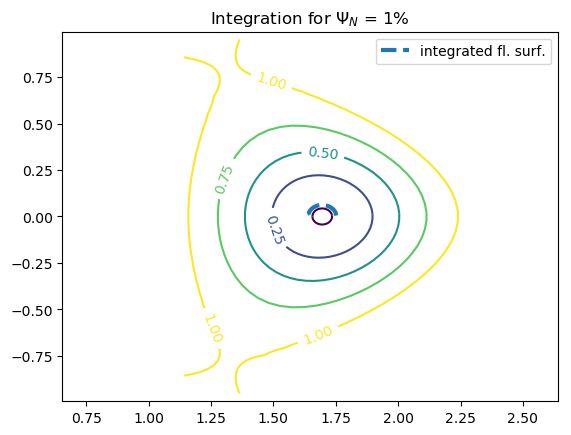

In [30]:
t = 2
sol = fs_integration(r_of_psi[t,3],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.title(L"Integration for $\Psi_N$ = 1%")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

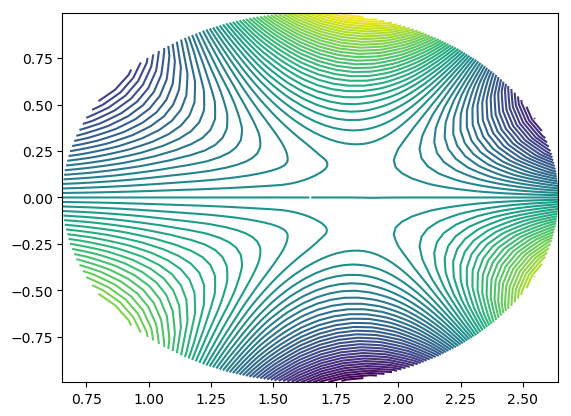

In [38]:
PyPlot.contour(X[:,:,1],Z[:,:,1],B1[:,:,1,2],60)
PyPlot.show()

Even with corrected flux, the integrator can't handle integration very close to the magnetic axis

We put a limit of 4%-95%

In [98]:
q = q_profile()

t=0
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
t=12
t=13
t=14
t=15
t=16
t=17
t=18
t=19
t=20
t=21
t=22
t=23
t=24
t=25


81×26 Array{Any,2}:
 -0.918641  -1.01541  -1.01462  -0.920688  …  -1.00192  -1.00134  -0.924955
 -0.932985  -1.01827  -1.01755  -0.935021     -1.00644  -1.00594  -0.939766
 -0.947576  -1.022    -1.02135  -0.949588     -1.01179  -1.01137  -0.955047
 -0.962421  -1.0266   -1.02602  -0.964402     -1.01802  -1.01768  -0.970582
 -0.977521  -1.03198  -1.03148  -0.979481     -1.02515  -1.02489  -0.986359
 -0.992882  -1.03805  -1.03765  -0.994838  …  -1.03317  -1.03299  -1.00246
 -1.00851   -1.04486  -1.04458  -1.01048      -1.04207  -1.04198  -1.01888
 -1.02441   -1.05254  -1.05238  -1.0264       -1.05188  -1.05187  -1.03559
 -1.04058   -1.06122  -1.06116  -1.0426       -1.06262  -1.06267  -1.05258
 -1.05704   -1.07101  -1.07106  -1.0591       -1.0743   -1.07442  -1.06987
 -1.07379   -1.08204  -1.08219  -1.07589   …  -1.08698  -1.08716  -1.08748
 -1.09083   -1.09441  -1.09464  -1.09298      -1.10064  -1.10085  -1.10541
 -1.10817   -1.10824  -1.10851  -1.11037      -1.11526  -1.11549  -1.12367


In [99]:
q_rscl = resizing_q(q);

In [101]:
psi_list = LinRange(0,1,100)

100-element LinRange{Float64}:
 0.0,0.010101,0.020202,0.030303,0.040404,…,0.969697,0.979798,0.989899,1.0

In [102]:
t_list = LinRange(0,25,26)

26-element LinRange{Float64}:
 0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,…,19.0,20.0,21.0,22.0,23.0,24.0,25.0

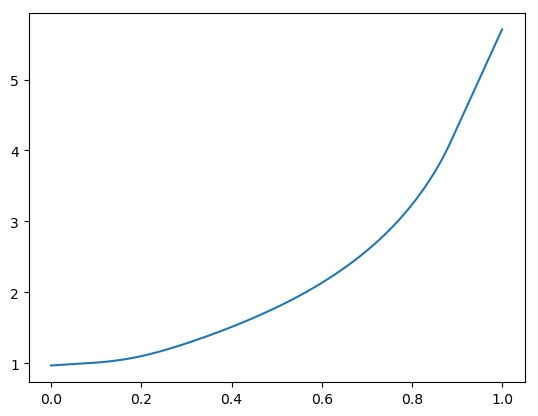

In [103]:
PyPlot.plot(psi_list,-q_rscl[:,20])
PyPlot.show()

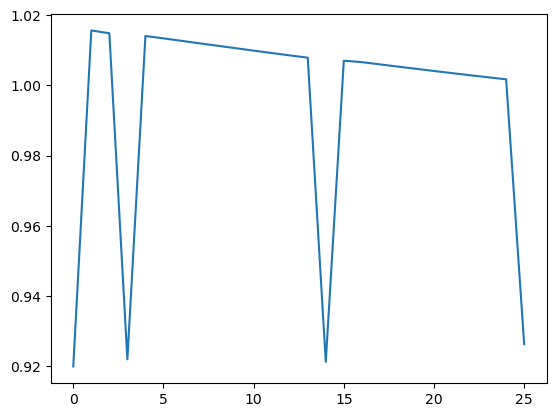

In [114]:
PyPlot.plot(t_list,-q_rscl[10,:])
PyPlot.show()

The problem is at t=14 (in zero-based numbering), i.e., in t=15. We should diagnose what is happening at t=14,15,16,17. The above plot is at zero-based $\Psi=10\%$. So we need to plot at position 11. 

## Diagnosing the above time steps at $\Psi=10\%$

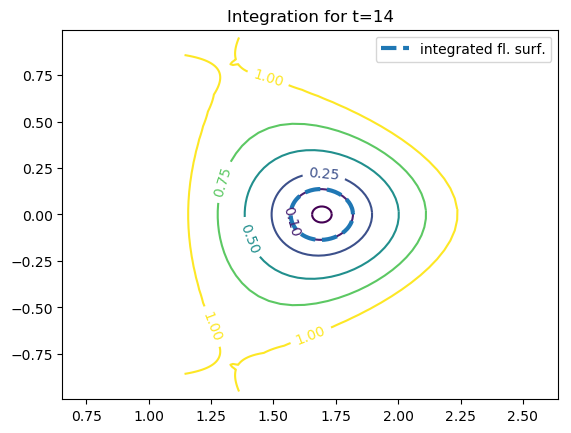

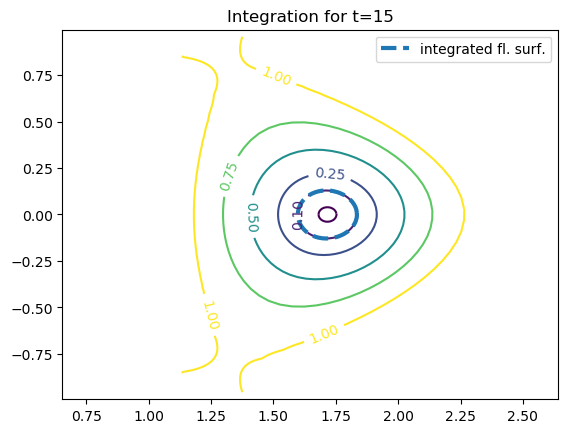

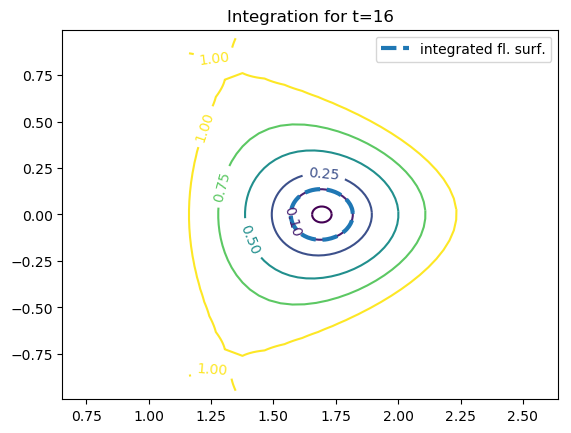

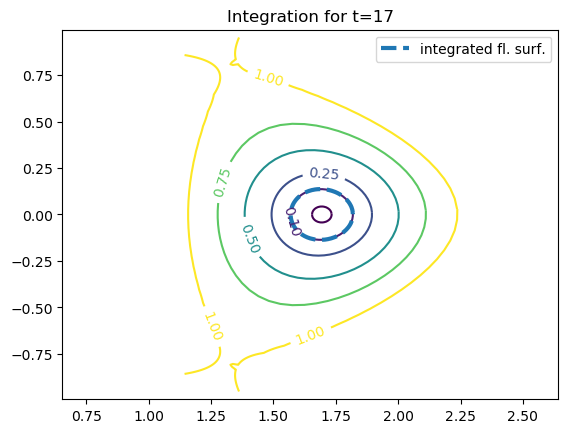

In [118]:
for t = [14,15,16,17]
    sol = fs_integration_B(r_of_psi[t,11],0.0,t-1);
    xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
    zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
    PyPlot.figure()
    PyPlot.title("Integration for t=$t")
    CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.10,0.25,0.5,0.75,1.0])
    PyPlot.clabel(CS,fmt="%1.2f")
    PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
    PyPlot.legend()
    PyPlot.show()
end

First observation is that the integration in all case, including the offending t=15 one, is spot on.

Lets monitor the integration for these few time steps to see the last one and confirm the different q-value.

## t=14

(t, u) = ([0.16832314732364023, 0.04909613299018462, -0.05753421044192237], 0.008268788086612721)
(t, u) = ([0.16802621974535029, 0.10749019557605305, -0.12595748280839925], 0.018094550563647397)
(t, u) = ([0.16774715523637634, 0.14631696748426573, -0.17145396700840312], 0.02461923742581751)
(t, u) = ([0.1670511043796718, 0.2208755368742636, -0.2588310871065409], 0.0371211025721777)
(t, u) = ([0.16676704503840836, 0.2462457495981637, -0.28856399344384065], 0.041365194587244844)
(t, u) = ([0.16645260111067103, 0.27213411681861505, -0.3189032611463019], 0.045689956539074886)
(t, u) = ([0.16547060671209418, 0.3428849807790438, -0.40182353481890865], 0.057474027668416784)
(t, u) = ([0.16452918694512014, 0.40136505964171637, -0.47038498594030564], 0.06716966573792275)
(t, u) = ([0.16387537645429257, 0.4383723951126838, -0.5137894866139644], 0.07328157626845498)
(t, u) = ([0.16259788661938904, 0.5045826870599348, -0.5914927113892399], 0.08416558247776351)
(t, u) = ([0.16185480551198125, 0.54

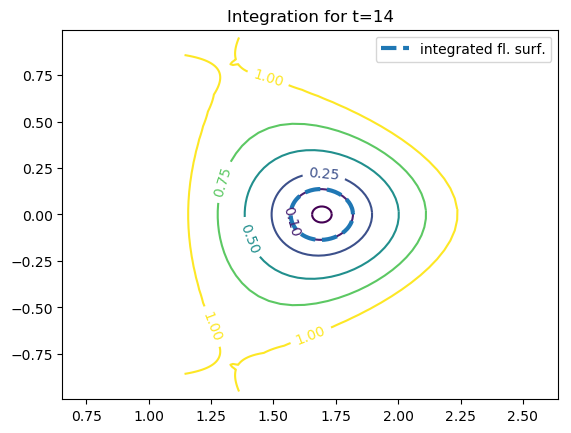

(t, u) = ([0.1492375366223636, 5.19280602670966, -5.070474824280224], 0.6274167344039763)
(t, u) = ([0.15057688702964891, 5.232269204840837, -5.1177049829449945], 0.6334824529866604)
(t, u) = ([0.15218312634745426, 5.281615587827263, -5.176611606375697], 0.6411235940953403)
(t, u) = ([0.15318336415087036, 5.313556870088744, -5.2146514872530245], 0.6461020993627656)
(t, u) = ([0.15473965855636013, 5.365271402980911, -5.276100199586231], 0.6542151877795286)
(t, u) = ([0.155638366582058, 5.396347604359112, -5.3129479054761], 0.6591209731120626)
(t, u) = ([0.15765577414346585, 5.469815892524945, -5.39984751440613], 0.6708060605509432)
(t, u) = ([0.15879894413992798, 5.514086625057396, -5.452083677974276], 0.6779037919077537)
(t, u) = ([0.15968729796520179, 5.550060003874772, -5.494470542916537], 0.6837008974031102)
(t, u) = ([0.16025166207663472, 5.573725242379293, -5.522330360507999], 0.6875284837018896)
(t, u) = ([0.16211602561494065, 5.657336699814377, -5.62063097654496], 0.701135203665

In [120]:
t=14
sol = fs_integration_B(r_of_psi[t,11],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.figure()
PyPlot.title("Integration for t=$t")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.10,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

## t=15

(t, u) = ([0.1841773157788924, 0.04804531882469682, -0.06002323127642185], 0.008859450668748794)
(t, u) = ([0.18381242423504232, 0.0879682154199684, -0.1098880879234611], 0.016214755094029774)
(t, u) = ([0.18352268387952705, 0.11197855349775435, -0.13987272449315727], 0.020634307034375455)
(t, u) = ([0.18308686641123265, 0.14240327598829483, -0.17786232932296966], 0.026228533342618536)
(t, u) = ([0.18255897626981432, 0.17404955683821635, -0.2173704129898258], 0.032038466105659955)
(t, u) = ([0.1821913962209348, 0.19383747706596033, -0.24207106017559296], 0.03566602073645031)
(t, u) = ([0.18124668694649257, 0.23891003625545998, -0.29832719733525676], 0.04391154023443116)
(t, u) = ([0.1800897324035527, 0.2864397876713982, -0.3576452362929997], 0.052577021615386396)
(t, u) = ([0.17924084240952717, 0.31771706599773536, -0.3966813037952816], 0.05826043218959133)
(t, u) = ([0.17847585780929268, 0.34398563121608217, -0.42946914536208447], 0.0630207771226006)
(t, u) = ([0.17782600436989598, 0.

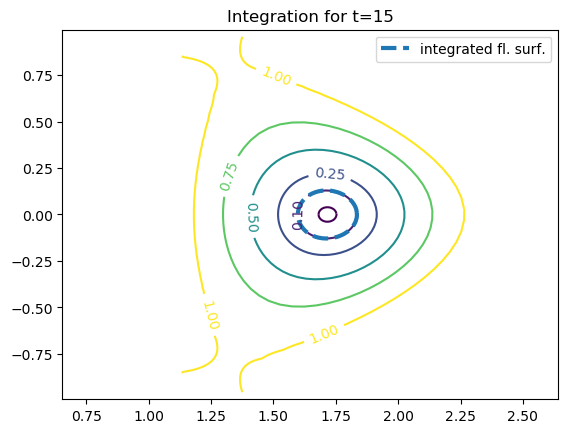

(t, u) = ([0.1482222192225902, 5.220305303974214, -4.535667700272486], 0.5742300925914117)
(t, u) = ([0.15068064496118166, 5.2578683035038765, -4.583660130979144], 0.5803589511347518)
(t, u) = ([0.15230047101838504, 5.283310780961188, -4.616136242887283], 0.5845398881135527)
(t, u) = ([0.1561466953498507, 5.346199613683726, -4.696265106941495], 0.5949750742921832)
(t, u) = ([0.15863480709080202, 5.388974920796045, -4.750626136354469], 0.6021530183148918)
(t, u) = ([0.16095329117654403, 5.430539156510431, -4.803327634435589], 0.6091881844053672)
(t, u) = ([0.16592054538077178, 5.526256554760348, -4.924233353793139], 0.6256065983858334)
(t, u) = ([0.16853580019019399, 5.581181120954142, -4.993339228210101], 0.6351575442147502)
(t, u) = ([0.17070878466116166, 5.629866595214352, -5.054453070600067], 0.6436974583941605)
(t, u) = ([0.17245849248952333, 5.671542522567517, -5.106681847087477], 0.6510597412972332)
(t, u) = ([0.17378986419633569, 5.705049426341545, -5.148625012673687], 0.6570116

In [121]:
t=15
sol = fs_integration_B(r_of_psi[t,11],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.figure()
PyPlot.title("Integration for t=$t")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.10,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

## t=16

(t, u) = ([0.1677259486256771, 0.04902251769049977, -0.05744345171300158], 0.008227091119289662)
(t, u) = ([0.16743073442662793, 0.10729547343642604, -0.1257178083620324], 0.017997702778601143)
(t, u) = ([0.1671582145195741, 0.14541370649612206, -0.17037864366030125], 0.02438069928095696)
(t, u) = ([0.1664982009188546, 0.21695586560670807, -0.25420913181713883], 0.036335447104803055)
(t, u) = ([0.16618117844139565, 0.24555307983603225, -0.28771862026993444], 0.04110293168235518)
(t, u) = ([0.16568680133976632, 0.2855842391484019, -0.3346235536615361], 0.047764050086871776)
(t, u) = ([0.16479669650182716, 0.34835865411585415, -0.40818200561958706], 0.05817592083671933)
(t, u) = ([0.16419514635970653, 0.3861898577179143, -0.45252326108097135], 0.06442817312084918)
(t, u) = ([0.16335643050751394, 0.4346141700667395, -0.5093000758270768], 0.07240346703351576)
(t, u) = ([0.16245637820887188, 0.482364470100524, -0.5653146667644948], 0.08023450574071594)
(t, u) = ([0.16183757930531328, 0.5132

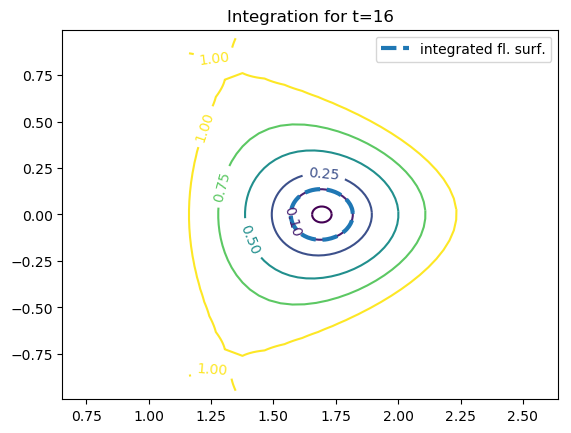

([0.07602259834386317, 3.287510718733226, -3.2394863945597034], 0.4077381255441197)
(t, u) = ([0.07672026403182633, 3.361086270388066, -3.286477055539842], 0.41339931900343124)
(t, u) = ([0.07723192742977084, 3.404031512670576, -3.3142533805354826], 0.4167442318958488)
(t, u) = ([0.07768462288095597, 3.4374959003895897, -3.336111163292861], 0.4193754595358966)
(t, u) = ([0.0785465752029487, 3.4933276182047024, -3.3730556090473374], 0.42382067513144867)
(t, u) = ([0.07915994464363893, 3.528549800279516, -3.3967072591136676], 0.42666486110725305)
(t, u) = ([0.08017710806498966, 3.581135572149436, -3.4325788985705437], 0.430975592641663)
(t, u) = ([0.08163565372784104, 3.647455171542148, -3.4788958939286814], 0.4365351270289549)
(t, u) = ([0.08255700278668664, 3.685294309168729, -3.5059191316714675], 0.43977517234549685)
(t, u) = ([0.08342153523000564, 3.7185718273568447, -3.530074231341806], 0.4426688946551723)
(t, u) = ([0.0846610223054273, 3.7631948062272413, -3.5630765681231624], 0.44

In [122]:
t=16
sol = fs_integration_B(r_of_psi[t,11],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.figure()
PyPlot.title("Integration for t=$t")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.10,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

It's obvious that the problem comes with the shifting of the point we take to be the magnetic axis

Lets try with integrating the same psi-line for all times

In [127]:
function const_q_profile()
    q = []
    for t in range(0, stop=size(B3)[4]-1)
        println("t=",t)
        for r in r_of_psi[15,psin_min_ind:psin_max_ind]
            sol = fs_integration_B(r,0.0,t)
            append!(q, last(sol[3,length(sol.t)])/(2.0*pi))
        end
    end
    q_fun = reshape(q,(psin_max_ind-psin_min_ind+1,size(B3)[4]))
    return q_fun
end

const_q_profile (generic function with 1 method)

In [128]:
qconst=const_q_profile()

t=0
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
t=12
t=13
t=14
t=15
t=16
t=17
t=18
t=19
t=20
t=21
t=22
t=23
t=24
t=25


┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /users/giannis_kx/.julia/packages/DiffEqBase/b38LC/src/integrator_interface.jl:329


81×26 Array{Any,2}:
 -1.0269   -1.0228   -1.02235  -0.918224  …  -1.01668  -1.0165   -0.416635
 -1.04594  -1.0281   -1.02778  -0.932436     -1.02461  -1.02456  -0.888748
 -1.065    -1.03432  -1.03414  -0.94688      -1.03366  -1.03374  -0.899764
 -1.0841   -1.04139  -1.04139  -0.961576     -1.04382  -1.04403  -0.910663
 -1.10328  -1.04947  -1.04967  -0.976538     -1.05512  -1.05545  -0.921803
 -1.12258  -1.05874  -1.05913  -0.991784  …  -1.06757  -1.06802  -0.93345
 -1.142    -1.06934  -1.06994  -1.00731      -1.08122  -1.08178  -0.94555
 -1.16157  -1.08145  -1.08225  -1.02313      -1.09607  -1.09671  -0.957948
 -1.18131  -1.09521  -1.09619  -1.03923      -1.11209  -1.11279  -0.970563
 -1.20123  -1.11073  -1.11186  -1.05562      -1.1292   -1.12994  -0.983399
 -1.22135  -1.12798  -1.12919  -1.07231   …  -1.1473   -1.14806  -0.996502
 -1.24168  -1.14675  -1.148    -1.08929      -1.16628  -1.16704  -1.00989
 -1.26224  -1.16683  -1.16806  -1.10658      -1.18602  -1.18678  -1.02355
  ⋮      

In [130]:
qconst_r = resizing_q(qconst);

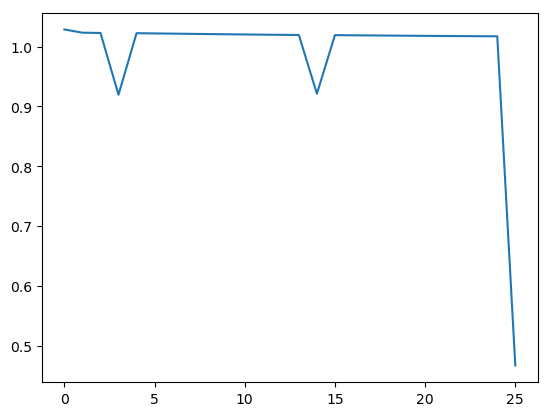

In [131]:
PyPlot.plot(t_list,-qconst_r[10,:])
PyPlot.show()

Same problem persists

Lets see how it looks

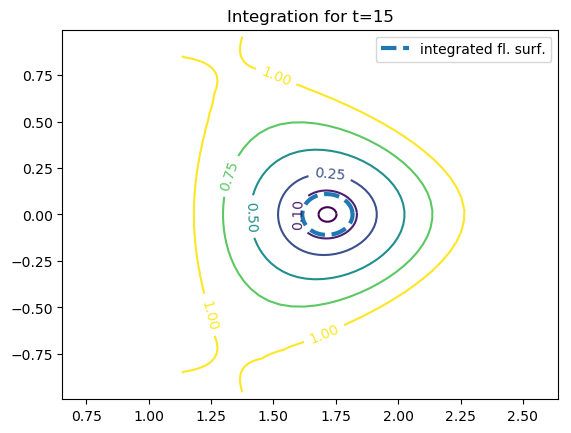

In [134]:
t=15
sol = fs_integration_B(r_of_psi[25,11],0.0,t-1);
xsol = [X_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
zsol = [Z_eint(sol[1,i],sol[2,i],0) for i in 1:length(sol.t)];
PyPlot.figure()
PyPlot.title("Integration for t=$t")
CS = PyPlot.contour(X[:,:,1],Z[:,:,1],(psi[:,:,t].-psi_min[t])/(norm[t]-psi_min[t]),levels=[0.01,0.10,0.25,0.5,0.75,1.0])
PyPlot.clabel(CS,fmt="%1.2f")
PyPlot.plot(xsol,zsol,linestyle="--",linewidth=3.0,label="integrated fl. surf.")
PyPlot.legend()
PyPlot.show()

It is off with respect to the flux surface. Which now begs the question if locating the magnetic axis is done properly